In [1]:
# jupyter auto reload
%load_ext autoreload
%autoreload 2

# Imports

In [2]:
#io
import ND2Loader
import os



# utils
import numpy as np
import segutils as su
import matplotlib.pyplot as plt

# segmentation
import torch_seg
import keras_seg
from MicroscopyPreprocessor import MicroscopyPreprocessor
import skimage.filters

from analysis import CellAnalyzer
    

Using TensorFlow backend.


Segmentation Models: using `keras` framework.


# Visualization Utilities
Functions for displaying images in a way to make counting detection disagreements easier.

In [3]:
def false_positive_mask(pred, truth):
    extras = pred - truth
    extras[extras < 0] = 0
    return extras
    
def false_negative_mask(pred, truth):
    missing = truth - pred
    missing[missing < 0] = 0
    return missing

def experimental_distance(disagreements):
    return disagreements

def experimental_loss(extras, missing, beta):
    return beta * extras + (1-beta) * missing

def mask_evaluation_fig(image, labeled_pred_mask, truth_thresh, extras_count, missing_count, researcher_num):
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 20))
    
    fig.suptitle(f'Researcher {researcher_num} comparison', size=30)
    
    binary_pred_mask = labeled_pred_mask.astype(bool).astype(int)

    extras__pred = false_positive_mask(binary_pred_mask, truth_thresh)
    missing__pred = false_negative_mask(binary_pred_mask, truth_thresh)

    ax1.set_title('False Positive Predicitons According to Researcher', size=20)
    ax1.imshow(extras__pred, cmap='gray')
    
    ax2.set_title('False Negative Predicitons According to Researcher', size=20)
    ax2.imshow(missing__pred, cmap='gray')

    ax3.set_title(f'Counted Extras in Prediction: {extras_count} Objects', size=20)
    ax3.imshow(su.visutils.apply_mask(image, su.imutils.label_mask(extras__pred)))

    ax4.set_title(f'Counted Missing in Prediction: {missing_count} Objects', size=20)
    ax4.imshow(su.visutils.apply_mask(image, su.imutils.label_mask(missing__pred)))
    
    fig.tight_layout()
    fig.subplots_adjust(top=0.92)
    plt.show()

def box_evaluation_fig(image, labeled_pred_mask, truth_thresh, extras_count, missing_count, researcher_num):
    labeled_truth = su.imutils.label_mask(truth_thresh)
    truth_boxes = su.imutils.get_bbox_for_all_objects(labeled_truth)
    pred_boxes = su.imutils.get_bbox_for_all_objects(labeled_pred_mask)
    
    title = (f'Researcher {researcher_num} comparison'
             'count extras in prediction (green only): {} objects\n'
             'count missing in prediction (red only): {} objects'.format(extras_count, missing_count))
    
    v = su.Visualizer(image)
    v.add_bbox_stack(truth_boxes, color='red').add_bbox_stack(pred_boxes, color='green')
    v.show(plot_title=title)
    
def full_evaluation(image, labeled_pred_mask, truth_thresh_res_1, extras_count_res_1, missing_count_res_1,
                    truth_thresh_res_2, extras_count_res_2, missing_count_res_2,
                    experimental_distance, beta, figtype):
    
    # plot for researcher 1
    figtype(image, labeled_pred_mask, truth_thresh_res_1, extras_count_res_1, missing_count_res_1, 1)
    
    # experimental loss compared to researcher 1
    experimental_loss_res_1 = experimental_loss(extras_count_res_1, missing_count_res_1, beta)
    print('Experimental Loss:', experimental_loss_res_1)
    
    # plot for researcher 2
    figtype(image, labeled_pred_mask, truth_thresh_res_2, extras_count_res_2, missing_count_res_2, 2)
    
    # experimental loss compared to researcher 2
    experimental_loss_res_2 = experimental_loss(extras_count_res_2, missing_count_res_2, beta)
    print('Experimental Loss:', experimental_loss_res_2)

    # check if the prediction is valid
    print()
    total_loss = experimental_loss_res_1 + experimental_loss_res_2
    print('Total Loss:', total_loss)
    print('Valid Prediction:', total_loss <= experimental_distance)

# Read Data
Prepare the evaluation data that will be tested with every model.

In [4]:
validation_set_dir = os.path.join('resources', 'images', 'validation_set')
researcher_1_dir_name = 'researcher_1'
researcher_2_dir_name = 'researcher_2'
validation_image_name = '2.nd2'

## Researcher 1 Data

In [5]:
nd2_reasearcher_1 = ND2Loader.read_nd2(os.path.join(validation_set_dir, researcher_1_dir_name, validation_image_name))
ph3_key, fluo_key, ph3_thresh_key, fluo_thresh_key = nd2_reasearcher_1.channels

ph3_res_1 = nd2_reasearcher_1.images[ph3_key][0]
fluo_res_1 = nd2_reasearcher_1.images[fluo_key][0]
ph3_thresh_res_1 = nd2_reasearcher_1.images[ph3_thresh_key][0].astype(bool).astype(int)
fluo_thresh_res_1 = nd2_reasearcher_1.images[fluo_thresh_key][0].astype(bool).astype(int)

/Users/guyazran/Desktop/School/Bachelor/Computer Science/Year 4/Semester A/Research Project/venv-bio/lib/python3.6/site-packages/nd2reader/raw_metadata.py:171: UserWarning: Z-levels details missing in metadata. Using Z-coordinates instead.
  warnings.warn("Z-levels details missing in metadata. Using Z-coordinates instead.")


## Researcher 2 Data

In [6]:
nd2_researcher_2 = ND2Loader.read_nd2(os.path.join(validation_set_dir, researcher_2_dir_name, validation_image_name))
ph3_key, fluo_key, ph3_thresh_key, fluo_thresh_key = nd2_researcher_2.channels

ph3_res_2 = nd2_researcher_2.images[ph3_key][0]
fluo_res_2 = nd2_researcher_2.images[fluo_key][0]
ph3_thresh_res_2 = nd2_researcher_2.images[ph3_thresh_key][0].astype(bool).astype(int)
fluo_thresh_res_2 = nd2_researcher_2.images[fluo_thresh_key][0].astype(bool).astype(int)

In [7]:
# check that that we read the same image data for both researchers

assert np.all(ph3_res_1 == ph3_res_2)
assert np.all(fluo_res_1 == fluo_res_2)
ph3 = ph3_res_1
fluo = fluo_res_1

# Researcher Distance
We would like to check how different the researchers are from each other. This is defined by the "experimental distance" which is the number of digreed segmented objects.

## Cell Segmentation

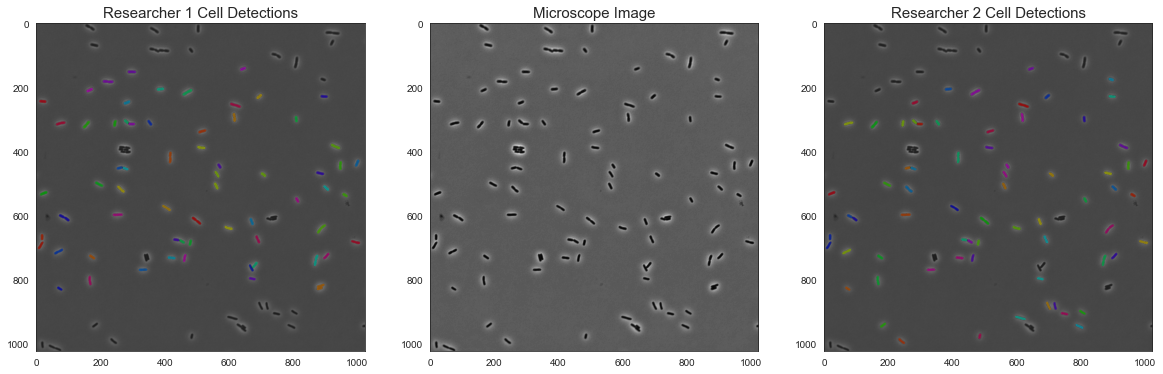

In [8]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 20))

ax1.set_title('Researcher 1 Cell Detections', size=15)
ax1.imshow(su.visutils.apply_mask(ph3, su.imutils.label_mask(ph3_thresh_res_1)))
ax2.set_title('Microscope Image', size=15)
ax2.imshow(ph3, cmap='gray')
ax3.set_title('Researcher 2 Cell Detections', size=15)
ax3.imshow(su.visutils.apply_mask(ph3, su.imutils.label_mask(ph3_thresh_res_2)))

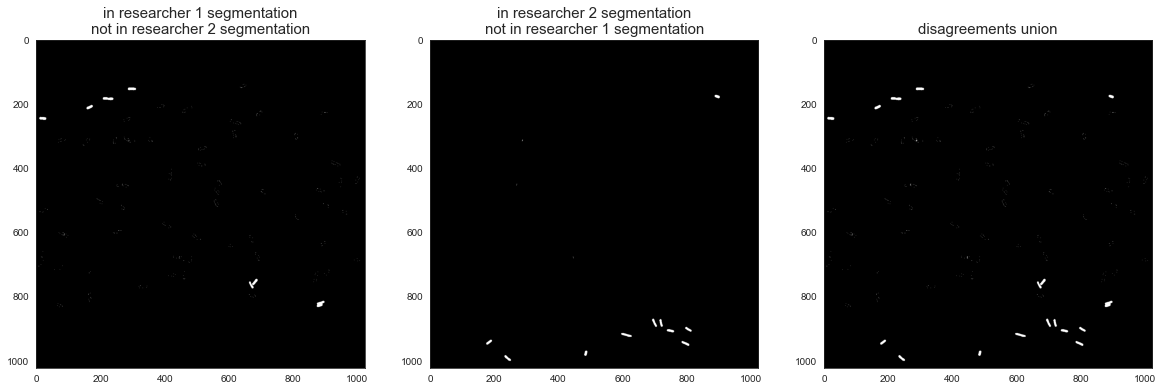

In [9]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 20))

extras_res_1 = false_positive_mask(ph3_thresh_res_1, ph3_thresh_res_2)
missing_res_1 = false_negative_mask(ph3_thresh_res_1, ph3_thresh_res_2)
disagree = extras_res_1 | missing_res_1

ax1.set_title('in researcher 1 segmentation\nnot in researcher 2 segmentation', size=15)
ax1.imshow(extras_res_1, cmap='gray')
ax2.set_title('in researcher 2 segmentation\nnot in researcher 1 segmentation', size=15)
ax2.imshow(missing_res_1, cmap='gray')
ax3.set_title('disagreements union', size=15)
ax3.imshow(disagree, cmap='gray')

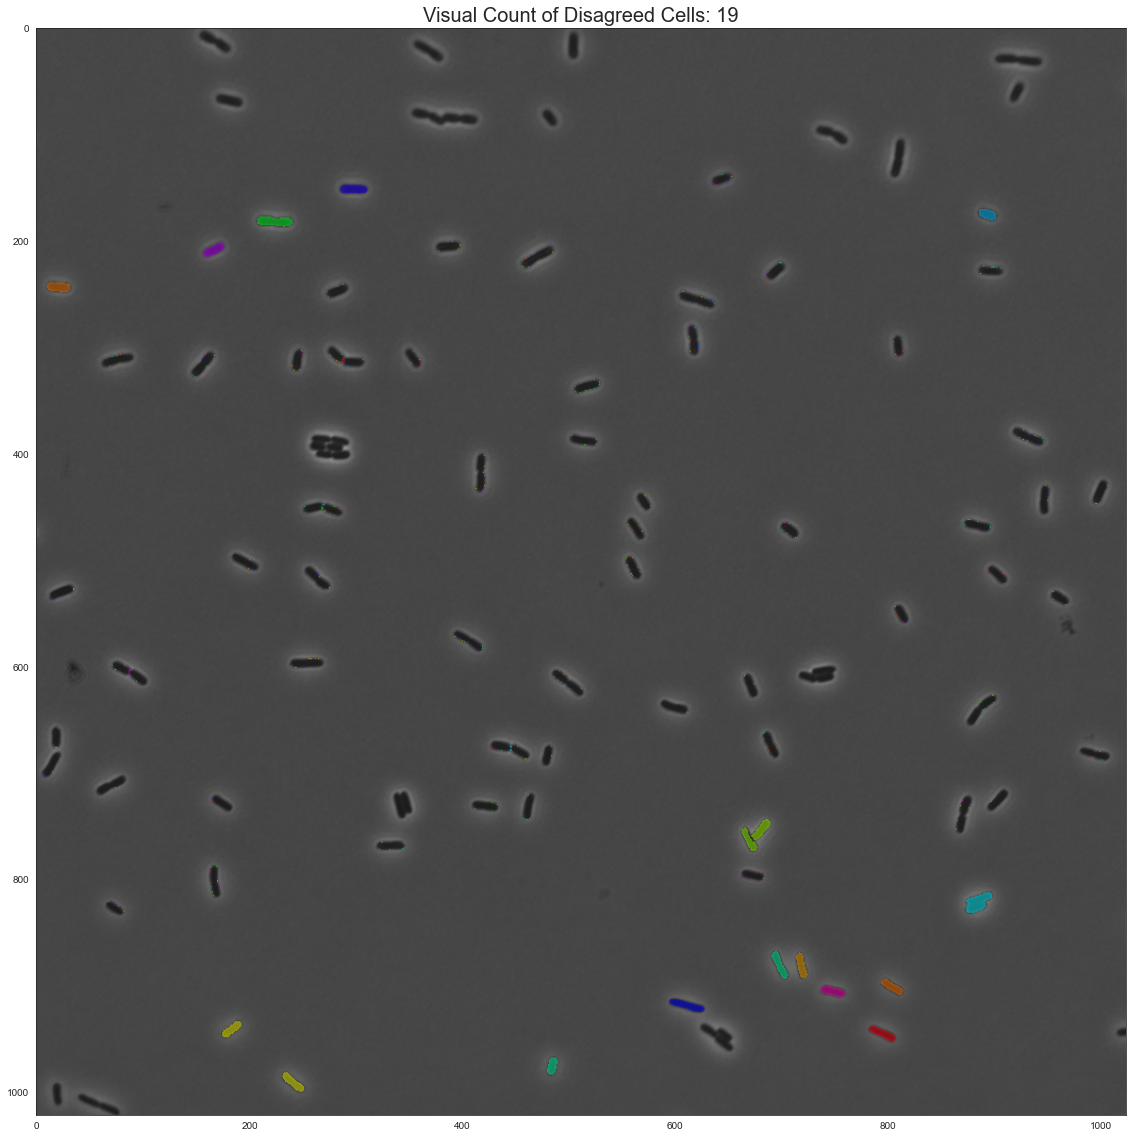

In [10]:
# calculate experimental distance
counted_cell_disagreements = 19

plt.figure(figsize=(20, 20))
plt.title(f'Visual Count of Disagreed Cells: {counted_cell_disagreements}', size=20)
labeled_disagree = su.imutils.label_mask(disagree)
masked = su.visutils.apply_mask(ph3, labeled_disagree)
plt.imshow(masked)

## Fluorescence Cluster Segmentations

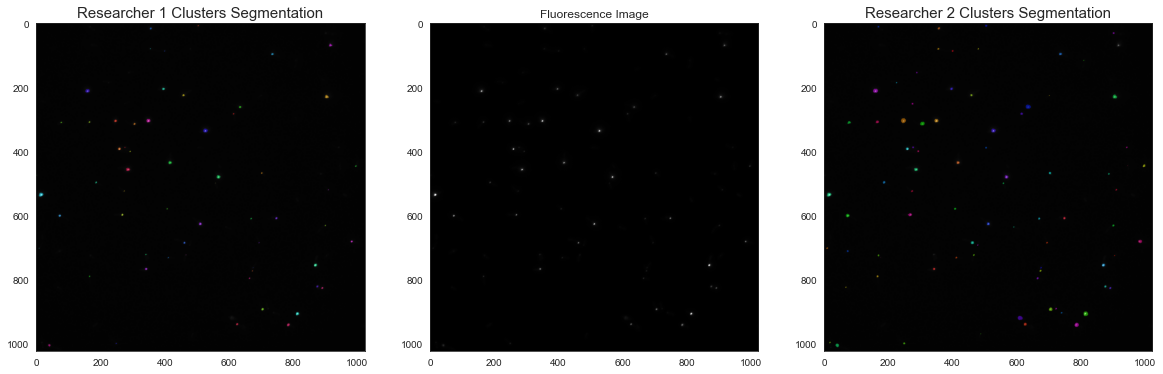

In [11]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 20))
ax1.set_title('Researcher 1 Clusters Segmentation', size=15)
ax1.imshow(su.visutils.apply_mask(fluo, su.imutils.label_mask(fluo_thresh_res_1)))
ax2.set_title('Fluorescence Image')
ax2.imshow(fluo, cmap='gray')
ax3.set_title('Researcher 2 Clusters Segmentation', size=15)
ax3.imshow(su.visutils.apply_mask(fluo, su.imutils.label_mask(fluo_thresh_res_2)))

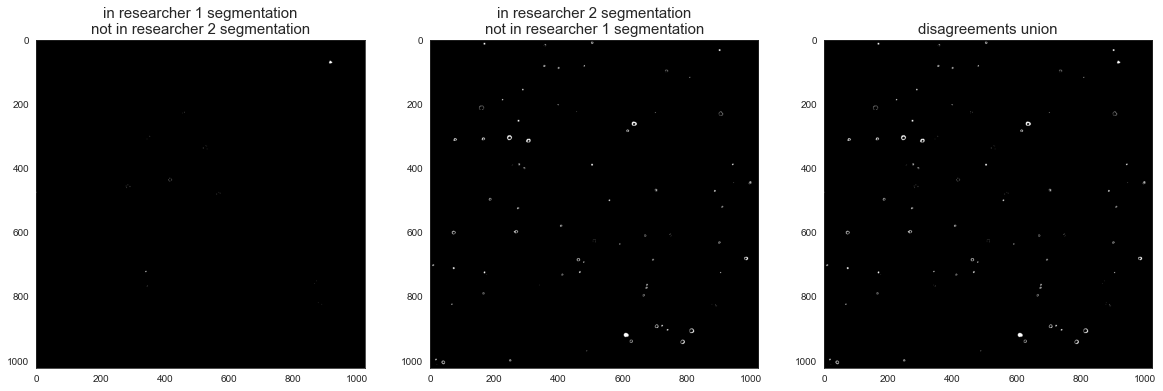

In [12]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 20))

extras_res_1 = false_positive_mask(fluo_thresh_res_1, fluo_thresh_res_2)
missing_res_1 = false_negative_mask(fluo_thresh_res_1, fluo_thresh_res_2)
disagree = extras_res_1 | missing_res_1

ax1.set_title('in researcher 1 segmentation\nnot in researcher 2 segmentation', size=15)
ax1.imshow(extras_res_1, cmap='gray')
ax2.set_title('in researcher 2 segmentation\nnot in researcher 1 segmentation', size=15)
ax2.imshow(missing_res_1, cmap='gray')
ax3.set_title('disagreements union', size=15)
ax3.imshow(disagree, cmap='gray')

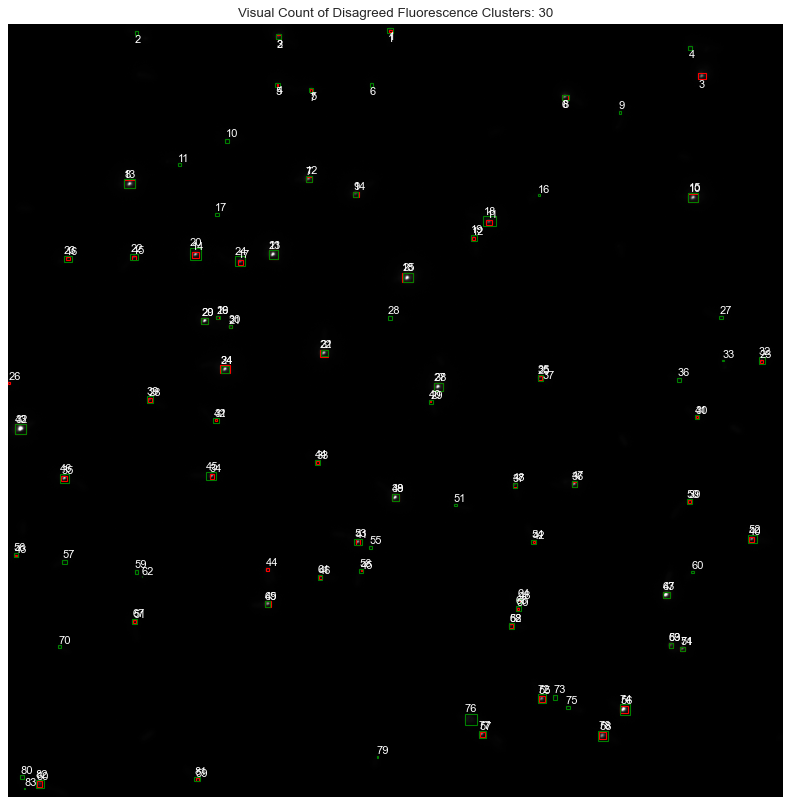

Fluorescence Clusters Segmentation Experimental Distance: 30


In [13]:
# calculate experimental distance
counted_fluo_disagreements = 30

res_1_boxes = su.imutils.get_bbox_for_all_objects(su.imutils.label_mask(fluo_thresh_res_1))
res_2_boxes = su.imutils.get_bbox_for_all_objects(su.imutils.label_mask(fluo_thresh_res_2))

v = su.Visualizer(fluo)
v.add_bbox_stack(res_1_boxes, color='red').add_bbox_stack(res_2_boxes, color='green')
v.show(plot_title=f'Visual Count of Disagreed Fluorescence Clusters: {counted_fluo_disagreements}')

print('Fluorescence Clusters Segmentation Experimental Distance:', counted_fluo_disagreements)

# Predictions Evaluation
For each model we calculate the "experimental loss", once for each researcher segmentation, and then sum the losses and check that it is lower than the experimental distance for that task. This tells us that a model provides valid predicitons.

## Cell Segmentation Models

In [14]:
# high beta means penalizing more on false positives
beta_cell = 0.7

### Baseline 1: Blank Mask (no detections)
Here we show that the evaluation method is not tolerant of empty masks.

In [15]:
cell_mask = np.zeros(ph3.shape, dtype=np.int)

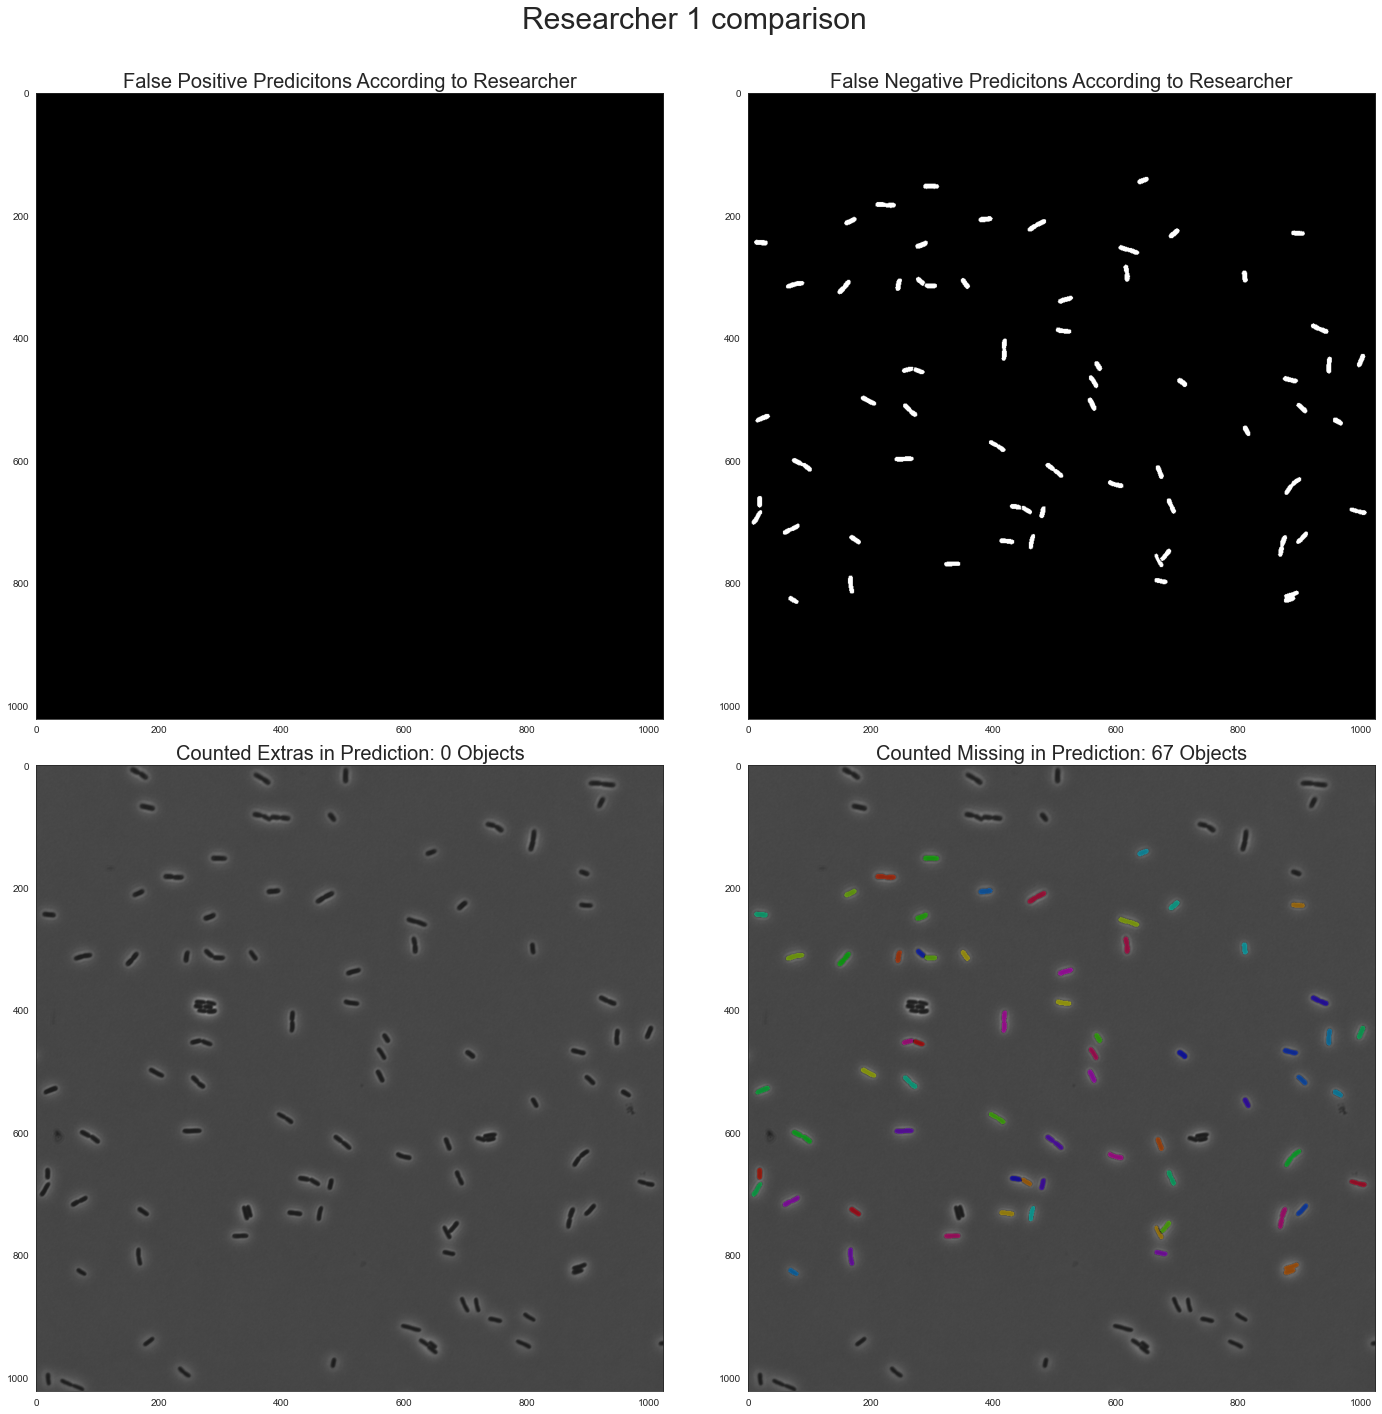

Experimental Loss: 20.1


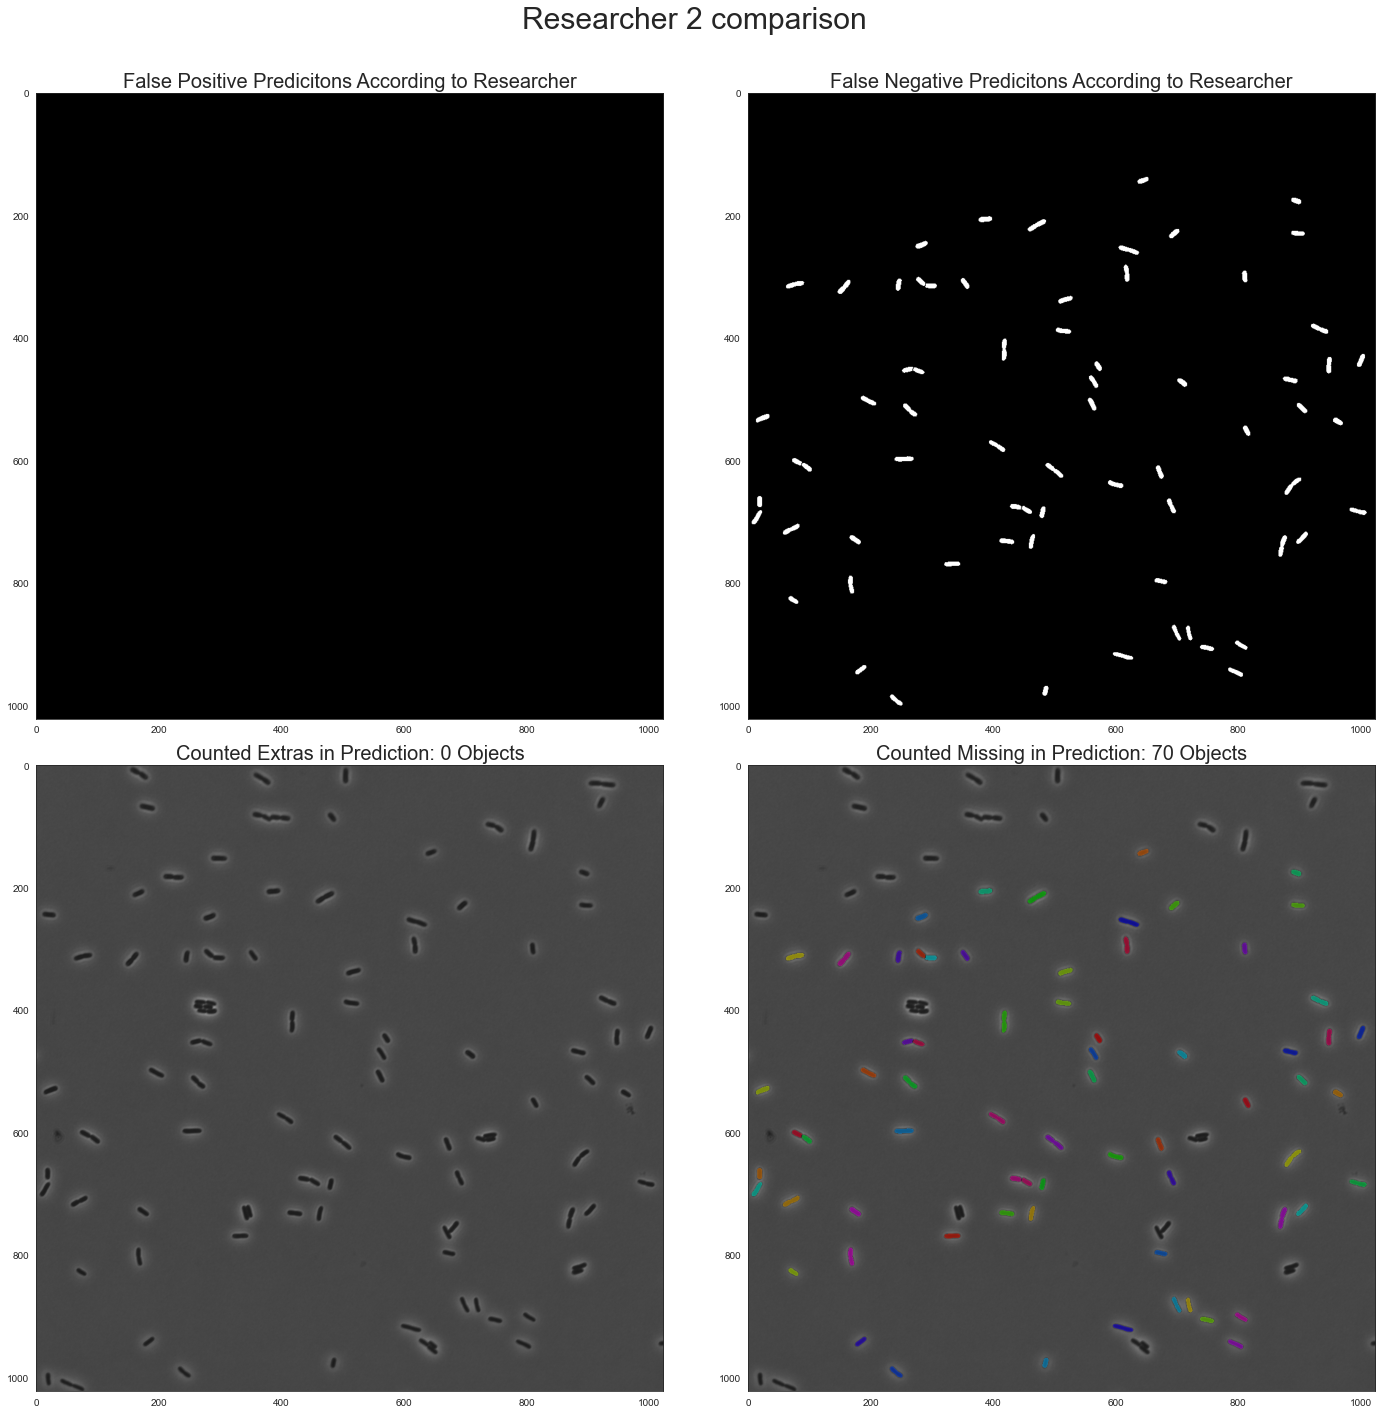

Experimental Loss: 21.000000000000004

Total Loss: 41.10000000000001
Valid Prediction: False


In [16]:
# visual count results for researcher 1
count_extras_res_1 = 0
count_missing_res_1 = 67

# visual count results for researcher 2
count_extras_res_2 = 0
count_missing_res_2 = 70

full_evaluation(ph3, cell_mask, ph3_thresh_res_1, count_extras_res_1, count_missing_res_1, ph3_thresh_res_2,
                count_extras_res_2, count_missing_res_2, counted_cell_disagreements, beta_cell, mask_evaluation_fig)

### Baseline 2: Thresholding
A simple deterministic model based on minimum thresholding.

In [17]:
eight_bit_ph3 = su.imutils.convert_16_bit_to_8_bit(ph3)

seg = skimage.filters.thresholding.threshold_minimum(eight_bit_ph3)
cell_mask = su.imutils.label_mask((eight_bit_ph3 < seg).astype(int))

#### Raw Thresholding
Looking at the thresholding result we see that almost all of the cells in the model. We show that this is not a good model by itself, and that we even prefer the blank mask!

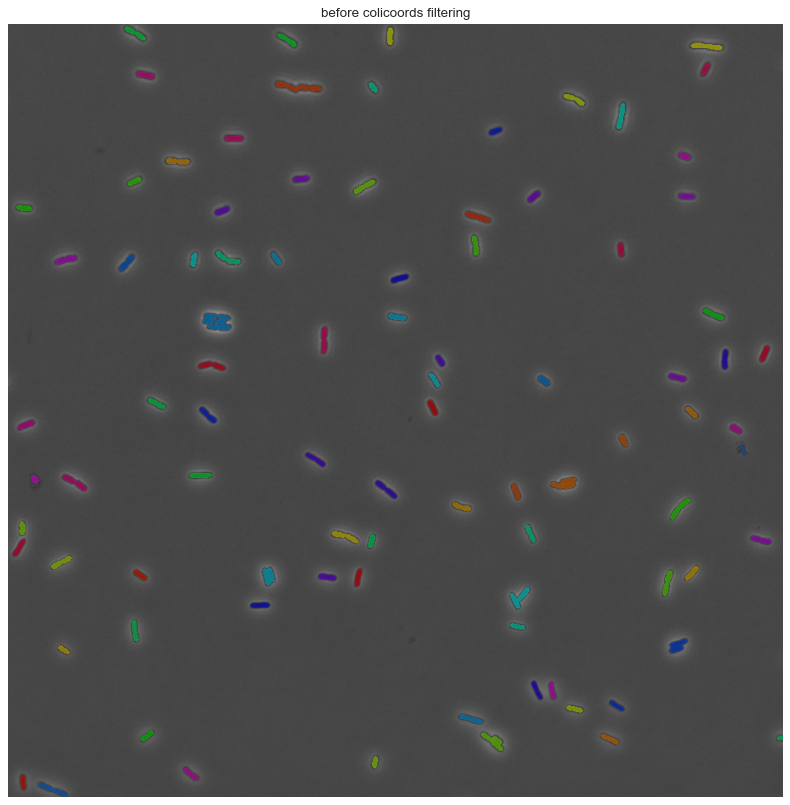

In [18]:
su.Visualizer(su.visutils.apply_mask(ph3, cell_mask)).show(plot_title='before colicoords filtering')

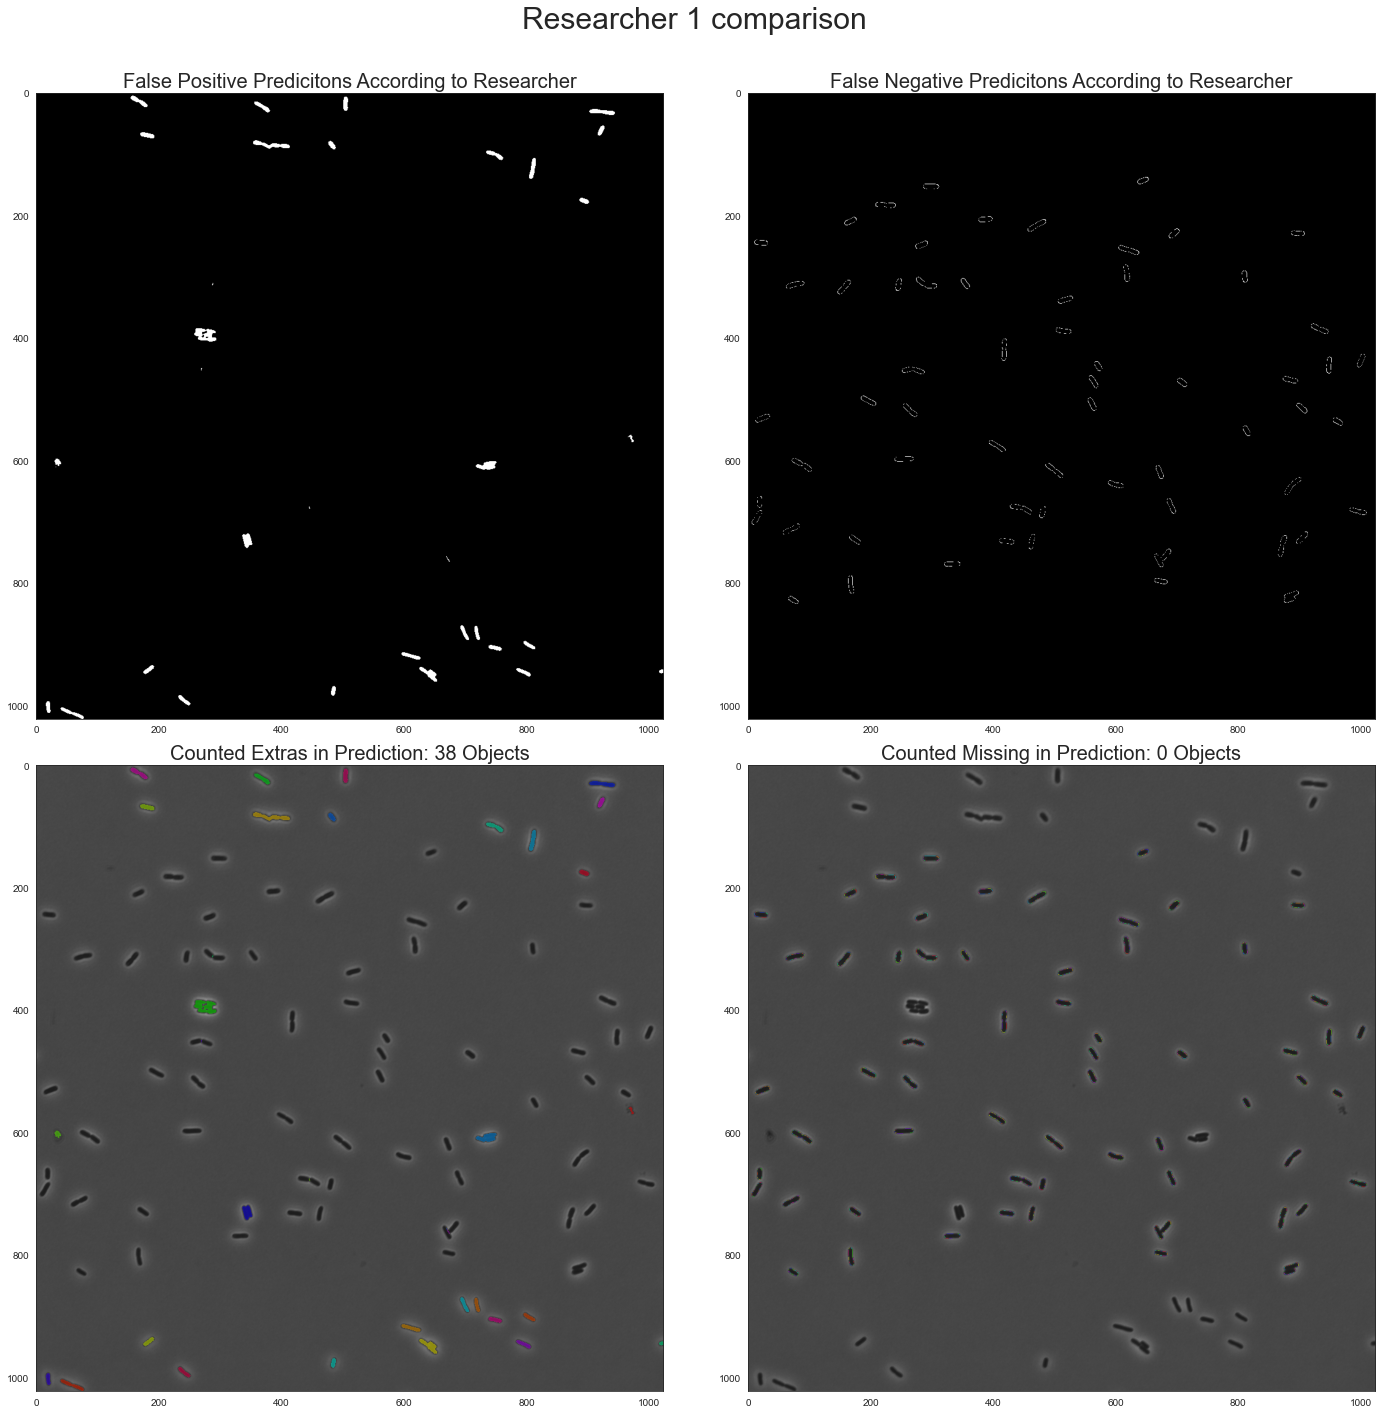

Experimental Loss: 26.599999999999998


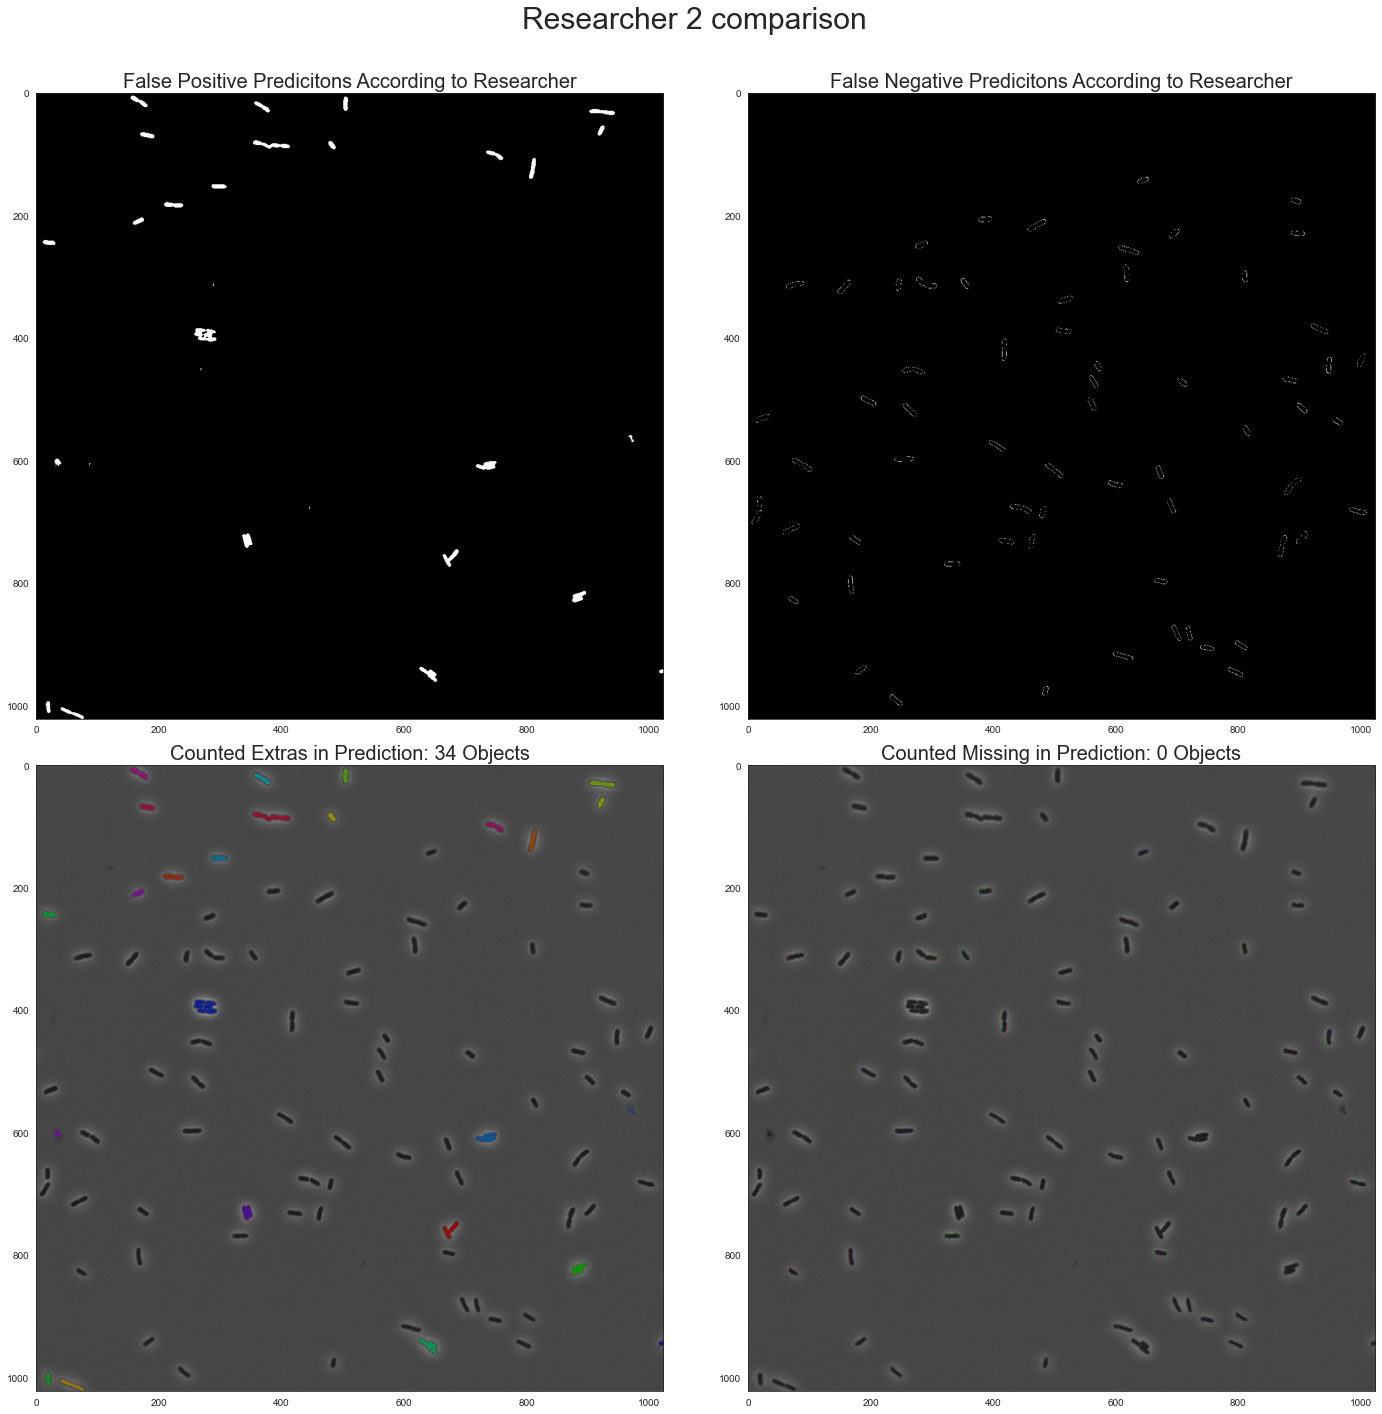

Experimental Loss: 23.799999999999997

Total Loss: 50.39999999999999
Valid Prediction: False


In [19]:
# visual count results for researcher 1
count_extras_res_1 = 38
count_missing_res_1 = 0

# visual count results for researcher 2
count_extras_res_2 = 34
count_missing_res_2 = 0

full_evaluation(ph3, cell_mask, ph3_thresh_res_1, count_extras_res_1, count_missing_res_1, ph3_thresh_res_2,
                count_extras_res_2, count_missing_res_2, counted_cell_disagreements, beta_cell, mask_evaluation_fig)

#### With CellAnalyzer Filtering
We push the thresholding mask through a CellAnalyzer object in order to check if deterministic filtering and Colicoords are enough to generate a valid prediction.

In [20]:
ca = CellAnalyzer(ph3, cell_mask)
cell_mask_cellanalyzer = ca.binary_image[0]

Cell 2 on image binary 0: object too small (may be noise)
Cell 12 on image binary 0: object too small (may be noise)
Cell 15 on image binary 0: object too small (may be noise)
Cell 19 on image binary 0: object too small (may be noise)
Cell 20 on image binary 0: object too small (may be noise)
Cell 24 on image binary 0: object too small (may be noise)
Cell 34 on image binary 0: object too small (may be noise)
Cell 36 on image binary 0: object too small (may be noise)
Cell 49 on image binary 0: object too small (may be noise)
Cell 50 on image binary 0: object too small (may be noise)
Cell 52 on image binary 0: object too small (may be noise)
Cell 58 on image binary 0: object too small (may be noise)
Cell 61 on image binary 0: object too small (may be noise)
Cell 75 on image binary 0: object too small (may be noise)
Cell 88 on image binary 0: object too small (may be noise)
Cell 89 on image binary 0: object too small (may be noise)
Cell 91 on image binary 0: object too small (may be noise

/Users/guyazran/Desktop/School/Bachelor/Computer Science/Year 4/Semester A/Research Project/venv-bio/lib/python3.6/site-packages/colicoords/cell.py:1346: RuntimeWarning: Mean of empty slice
  y = np.array([np.nanmean(np.where(im_y == y, im_x, np.nan)) for y in x_range])


Cell 74 on image binary 0: error during optimization: 



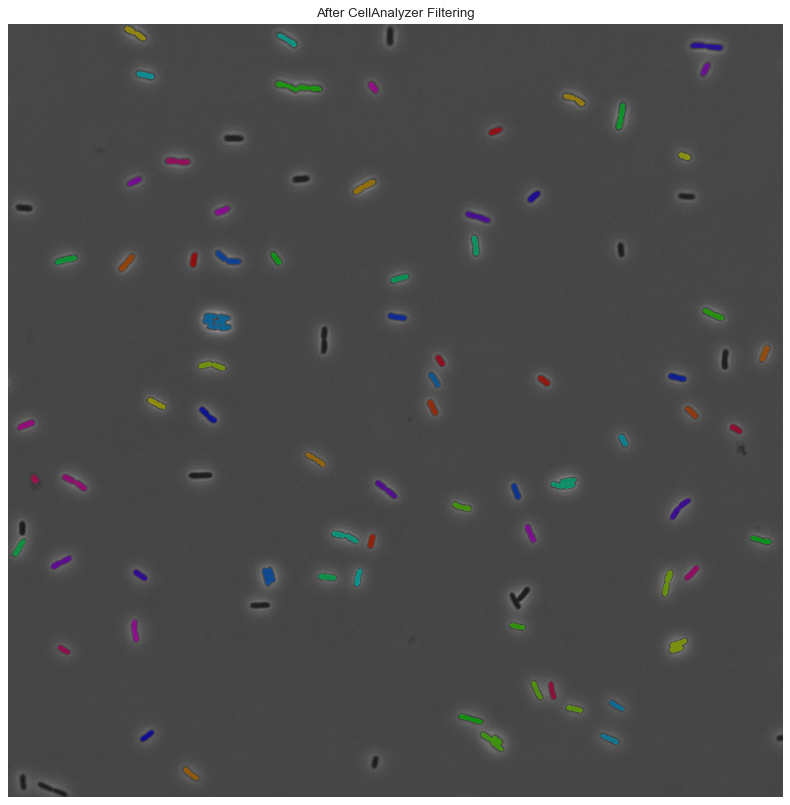

In [21]:
su.Visualizer(su.visutils.apply_mask(ph3, cell_mask_cellanalyzer)).show(plot_title='After CellAnalyzer Filtering')

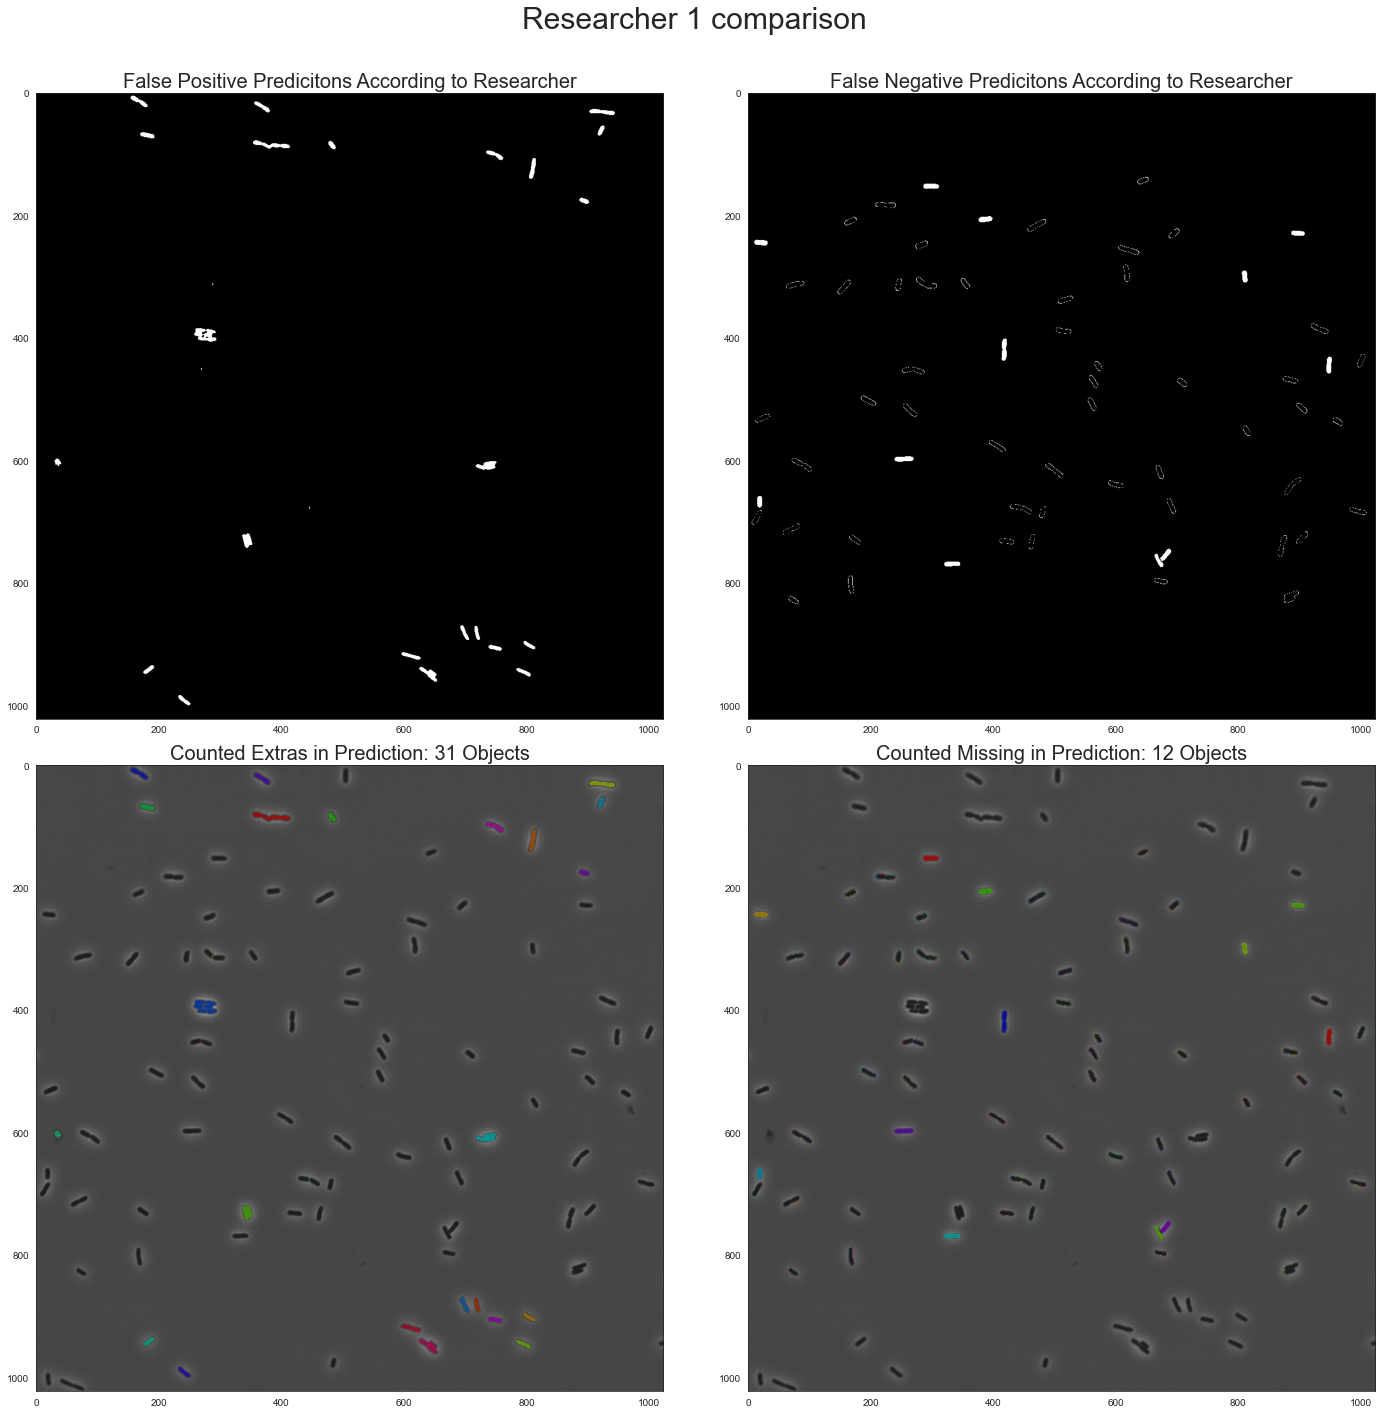

Experimental Loss: 25.3


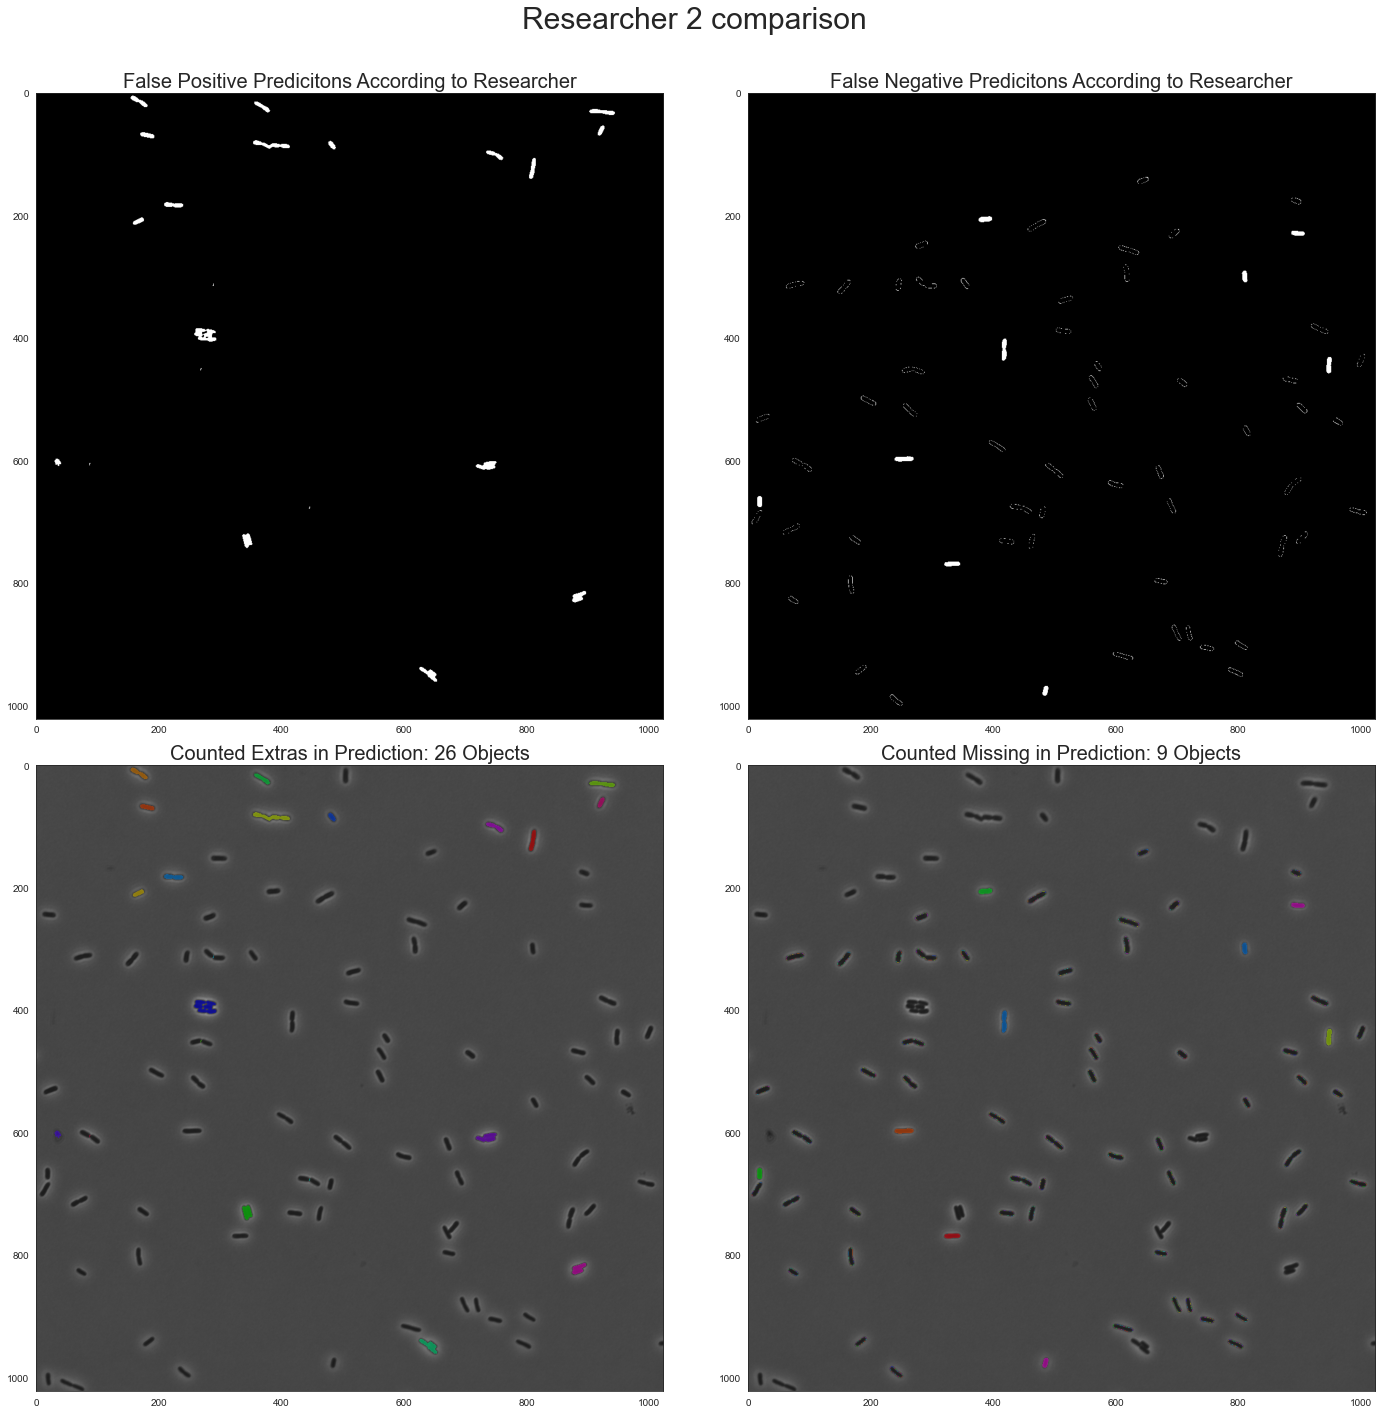

Experimental Loss: 20.9

Total Loss: 46.2
Valid Prediction: False


In [22]:
# visual count results for researcher 1
count_extras_res_1 = 31
count_missing_res_1 = 12

# visual count results for researcher 2
count_extras_res_2 = 26
count_missing_res_2 = 9

full_evaluation(ph3, cell_mask_cellanalyzer, ph3_thresh_res_1, count_extras_res_1, count_missing_res_1,
                ph3_thresh_res_2, count_extras_res_2, count_missing_res_2, counted_cell_disagreements, beta_cell,
                mask_evaluation_fig)

### U-Net
U-Net segmentation model (https://arxiv.org/pdf/1505.04597.pdf).

This model provides visually seeming good predictions, but they do not qualify as valid predictions.

In [23]:
model_pred_mask, cell_boxes = keras_seg.full_segmentation(
    ph3[None],
    'resources/models/config/cells_unet.yaml',
    'resources/models/weights/cells_unet_keras.hd5',
    preprocessor=MicroscopyPreprocessor,
    threshold=0.5,
)

# push through CellAnalyzer
ca = CellAnalyzer(ph3, model_pred_mask)
cell_mask = ca.binary_image[0]

Instructions for updating:
Colocations handled automatically by placer.



Cell 1 on image binary 0: object too small (may be noise)
Cell 2 on image binary 0: object too small (may be noise)
Cell 3 on image binary 0: object too small (may be noise)
Cell 4 on image binary 0: object too small (may be noise)
Cell 5 on image binary 0: object too small (may be noise)
Cell 6 on image binary 0: object too small (may be noise)
Cell 7 on image binary 0: object too small (may be noise)
Cell 8 on image binary 0: object too small (may be noise)
Cell 10 on image binary 0: object too small (may be noise)
Cell 11 on image binary 0: object too small (may be noise)
Cell 12 on image binary 0: object too small (may be noise)
Cell 13 on image binary 0: object too small (may be noise)
Cell 14 on image binary 0: object too small (may be noise)
Cell 17 on image binary 0: object too small (may be noise)
Cell 18 on image binary 0: object too small (may be noise)
Cell 19 on image binary 0: object too small (may be noise)
Cell 20 on image binary 0: object too small (may be noise)
Cell

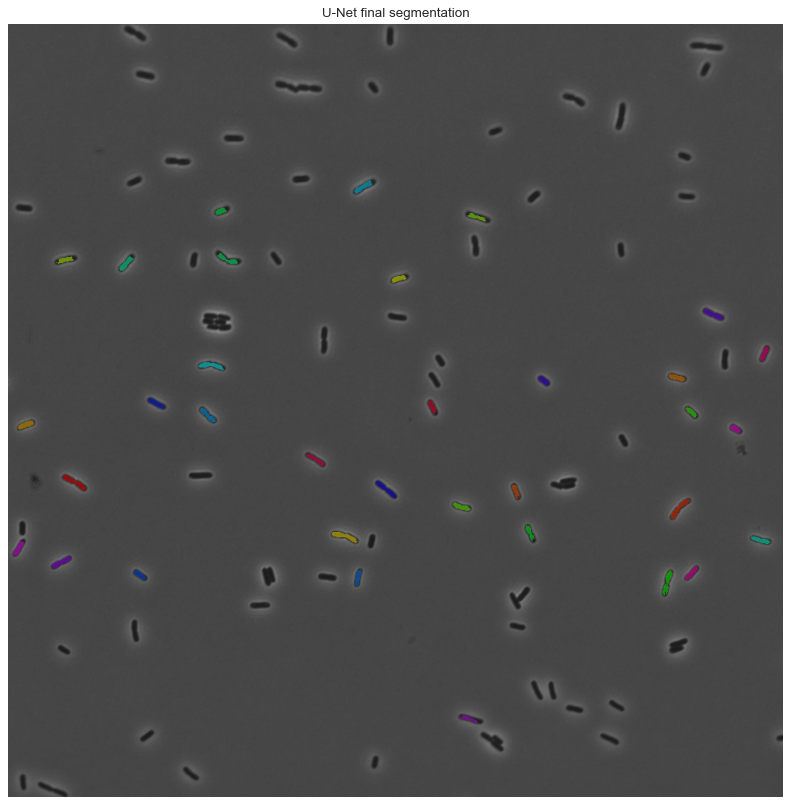

In [24]:
su.Visualizer(su.visutils.apply_mask(ph3, cell_mask)).show(plot_title='U-Net final segmentation')

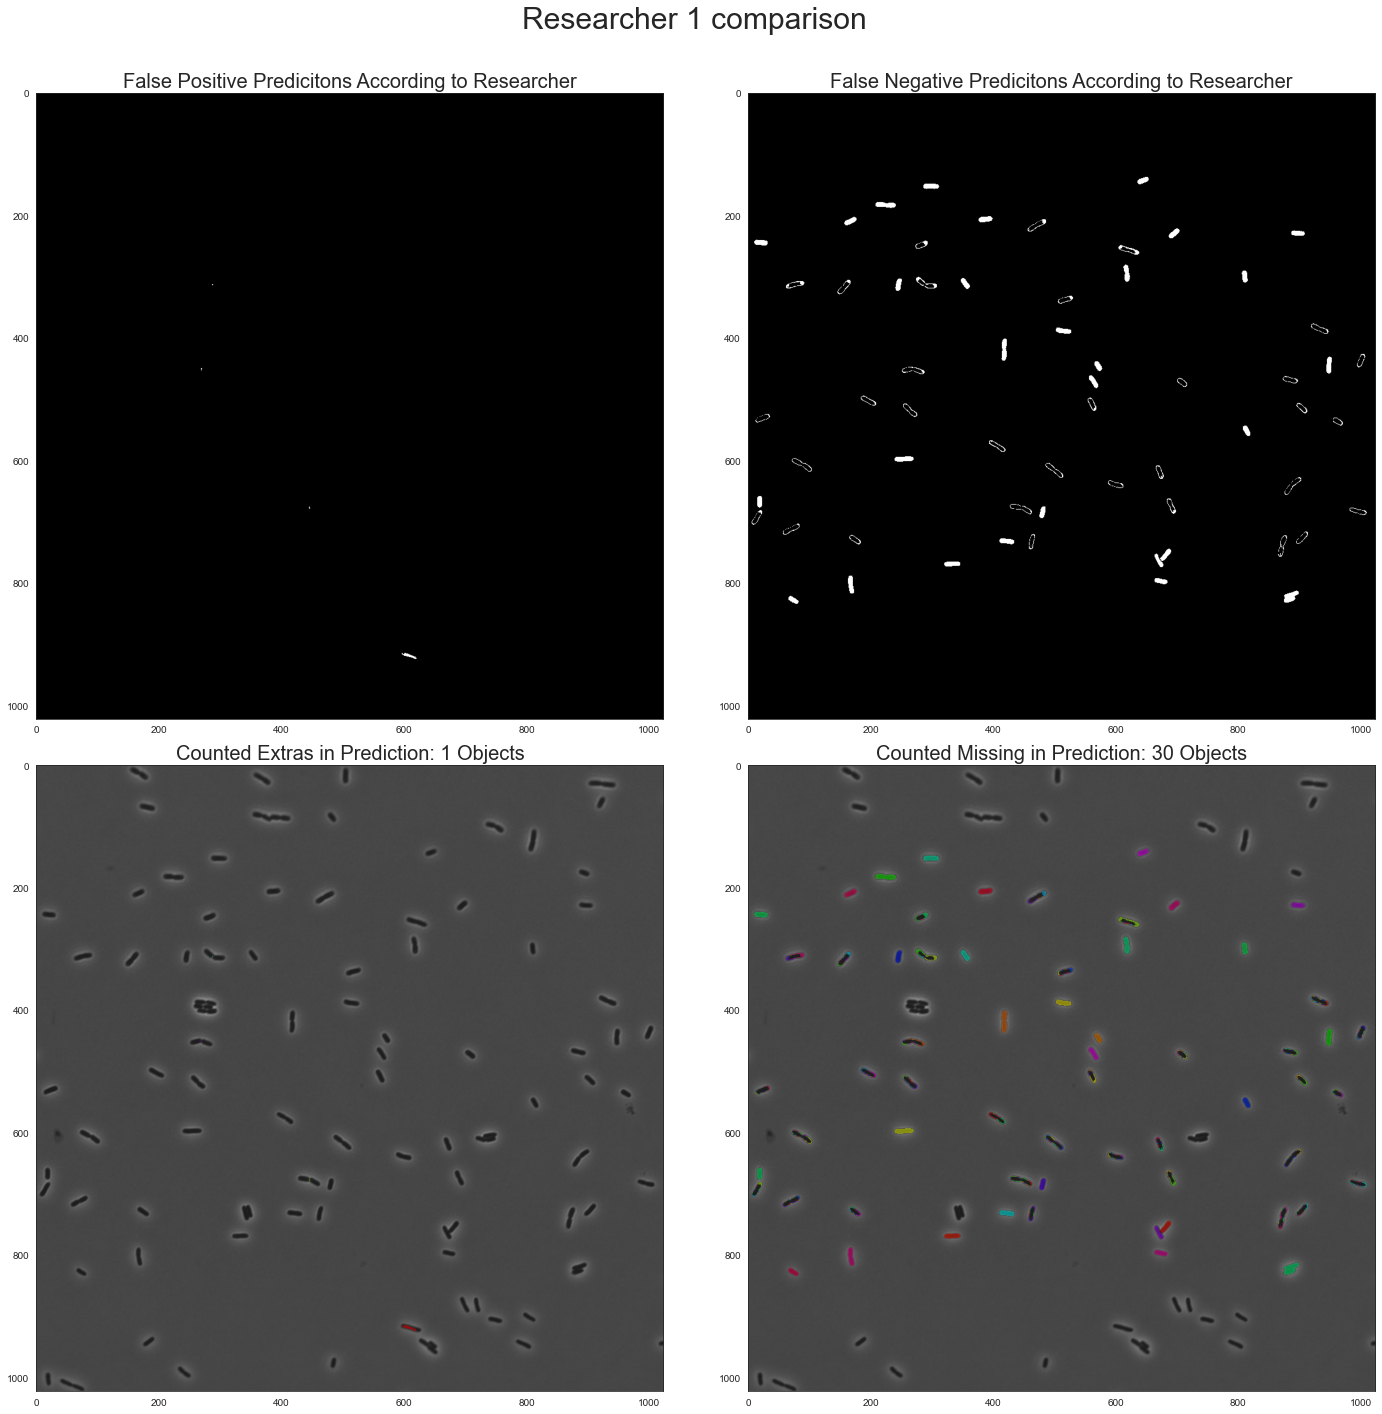

Experimental Loss: 9.700000000000001


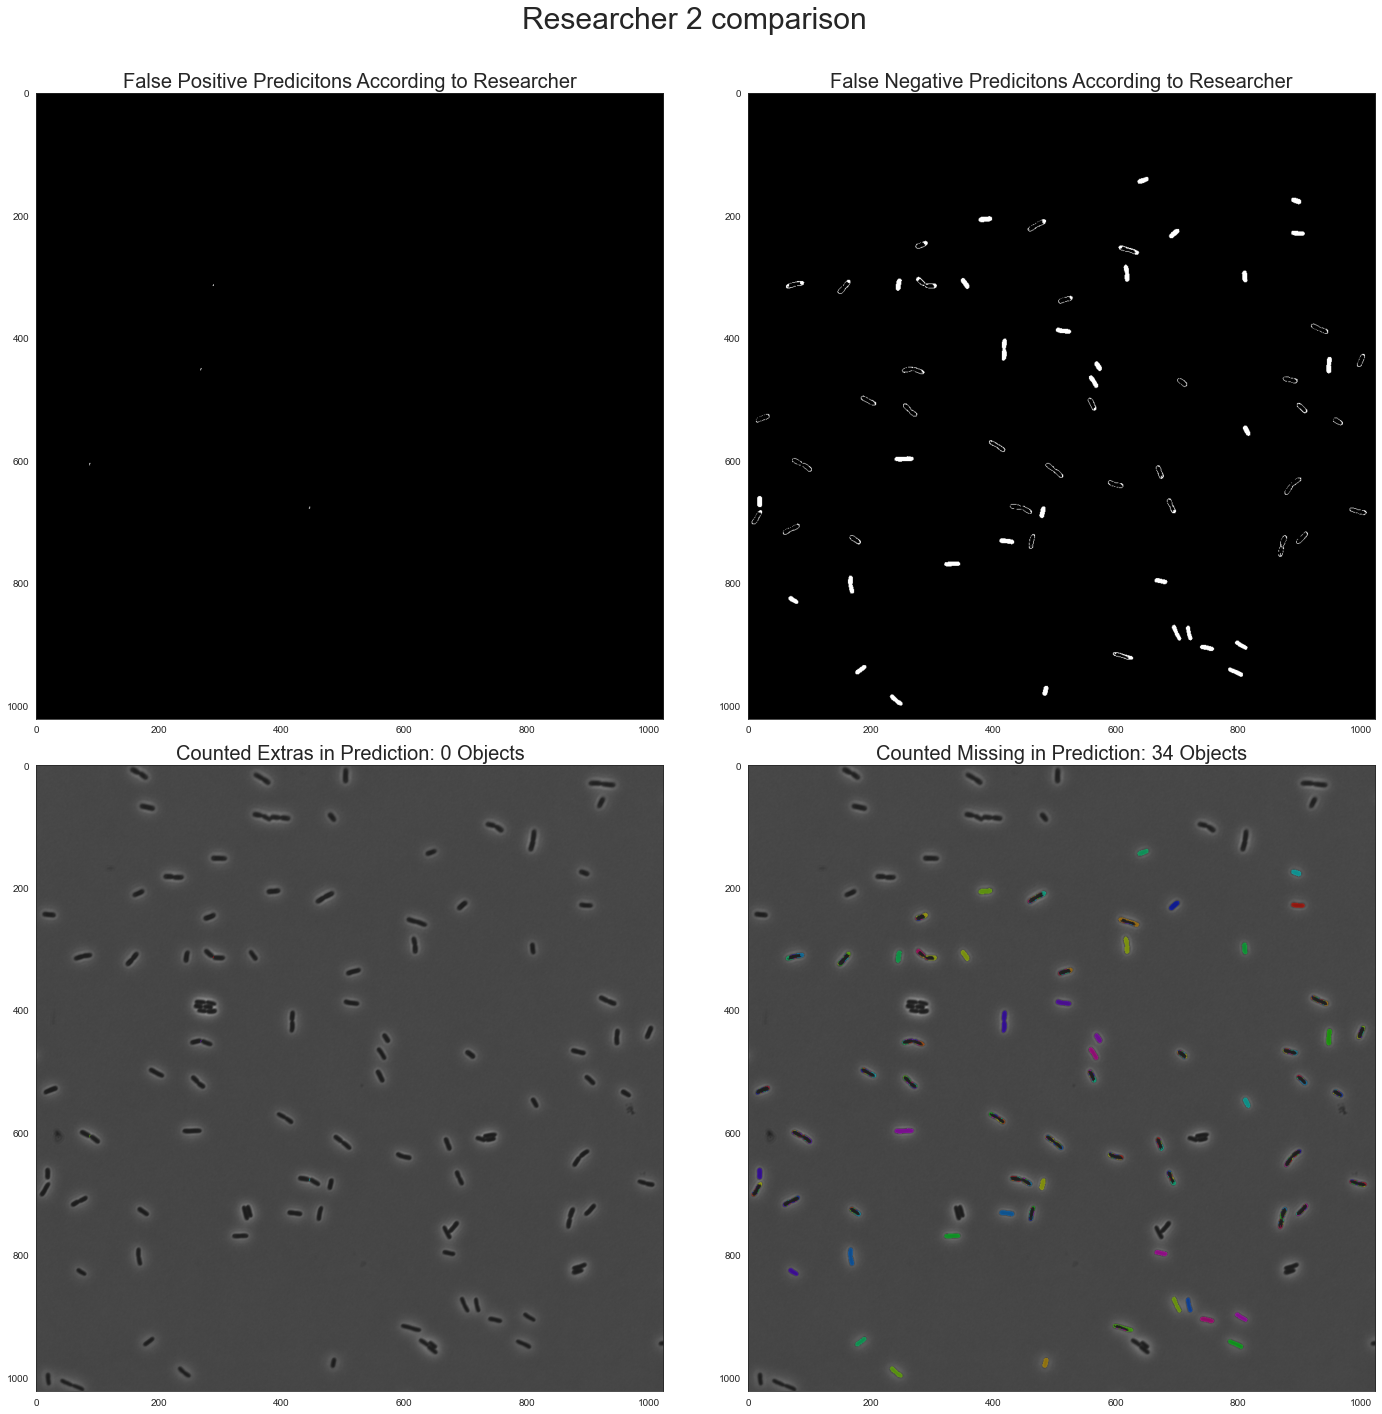

Experimental Loss: 10.200000000000001

Total Loss: 19.900000000000002
Valid Prediction: False


In [25]:
# visual count results for researcher 1
count_extras_res_1 = 1
count_missing_res_1 = 30

# visual count results for researcher 2
count_extras_res_2 = 0
count_missing_res_2 = 34

full_evaluation(ph3, cell_mask, ph3_thresh_res_1, count_extras_res_1, count_missing_res_1, ph3_thresh_res_2,
                count_extras_res_2, count_missing_res_2, counted_cell_disagreements, beta_cell, mask_evaluation_fig)

### Mask-RCNN
Mask-RCNN detection model (https://arxiv.org/pdf/1703.06870.pdf).

This is a good model that is valid for all validation images, and is therefore the chosen cell segmentation model in MicroAnalyzer.

In [26]:
# perform prediction.
model_pred_mask, boxes = torch_seg.full_segmentation(
    ph3[None],
    'resources/models/weights/cells_mask_rcnn_torch.pkl',
    threshold=0.95,
)

# push through CellAnalyzer
ca = CellAnalyzer(ph3, model_pred_mask)
cell_mask = ca.binary_image[0]

/Users/guyazran/Desktop/School/Bachelor/Computer Science/Year 4/Semester A/Research Project/venv-bio/lib/python3.6/site-packages/torchvision/ops/boxes.py:101: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  ../torch/csrc/utils/python_arg_parser.cpp:766.)
  keep = keep.nonzero().squeeze(1)



Cell 10 on image binary 0: object too small (may be noise)
Cell 17 on image binary 0: object too small (may be noise)
Cell 24 on image binary 0: object too small (may be noise)
Cell 26 on image binary 0: object too small (may be noise)
Cell 27 on image binary 0: object too small (may be noise)
Cell 33 on image binary 0: object too small (may be noise)
Cell 34 on image binary 0: object too small (may be noise)
Cell 43 on image binary 0: object too small (may be noise)
Cell 45 on image binary 0: object too small (may be noise)
Cell 46 on image binary 0: object too small (may be noise)
Cell 49 on image binary 0: object too small (may be noise)
Cell 53 on image binary 0: object too small (may be noise)
Cell 55 on image binary 0: object too small (may be noise)
Cell 56 on image binary 0: object too small (may be noise)
Cell 57 on image binary 0: object too small (may be noise)
Cell 58 on image binary 0: object too small (may be noise)
Cell 59 on image binary 0: object too small (may be noi

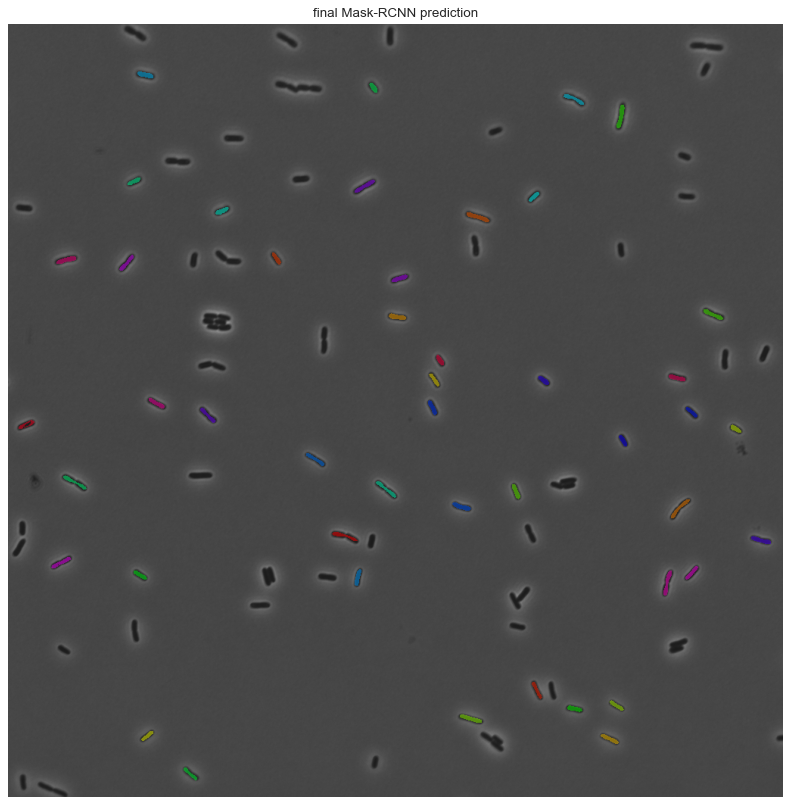

In [27]:
su.Visualizer(su.visutils.apply_mask(ph3, cell_mask)).show(plot_title='final Mask-RCNN prediction')

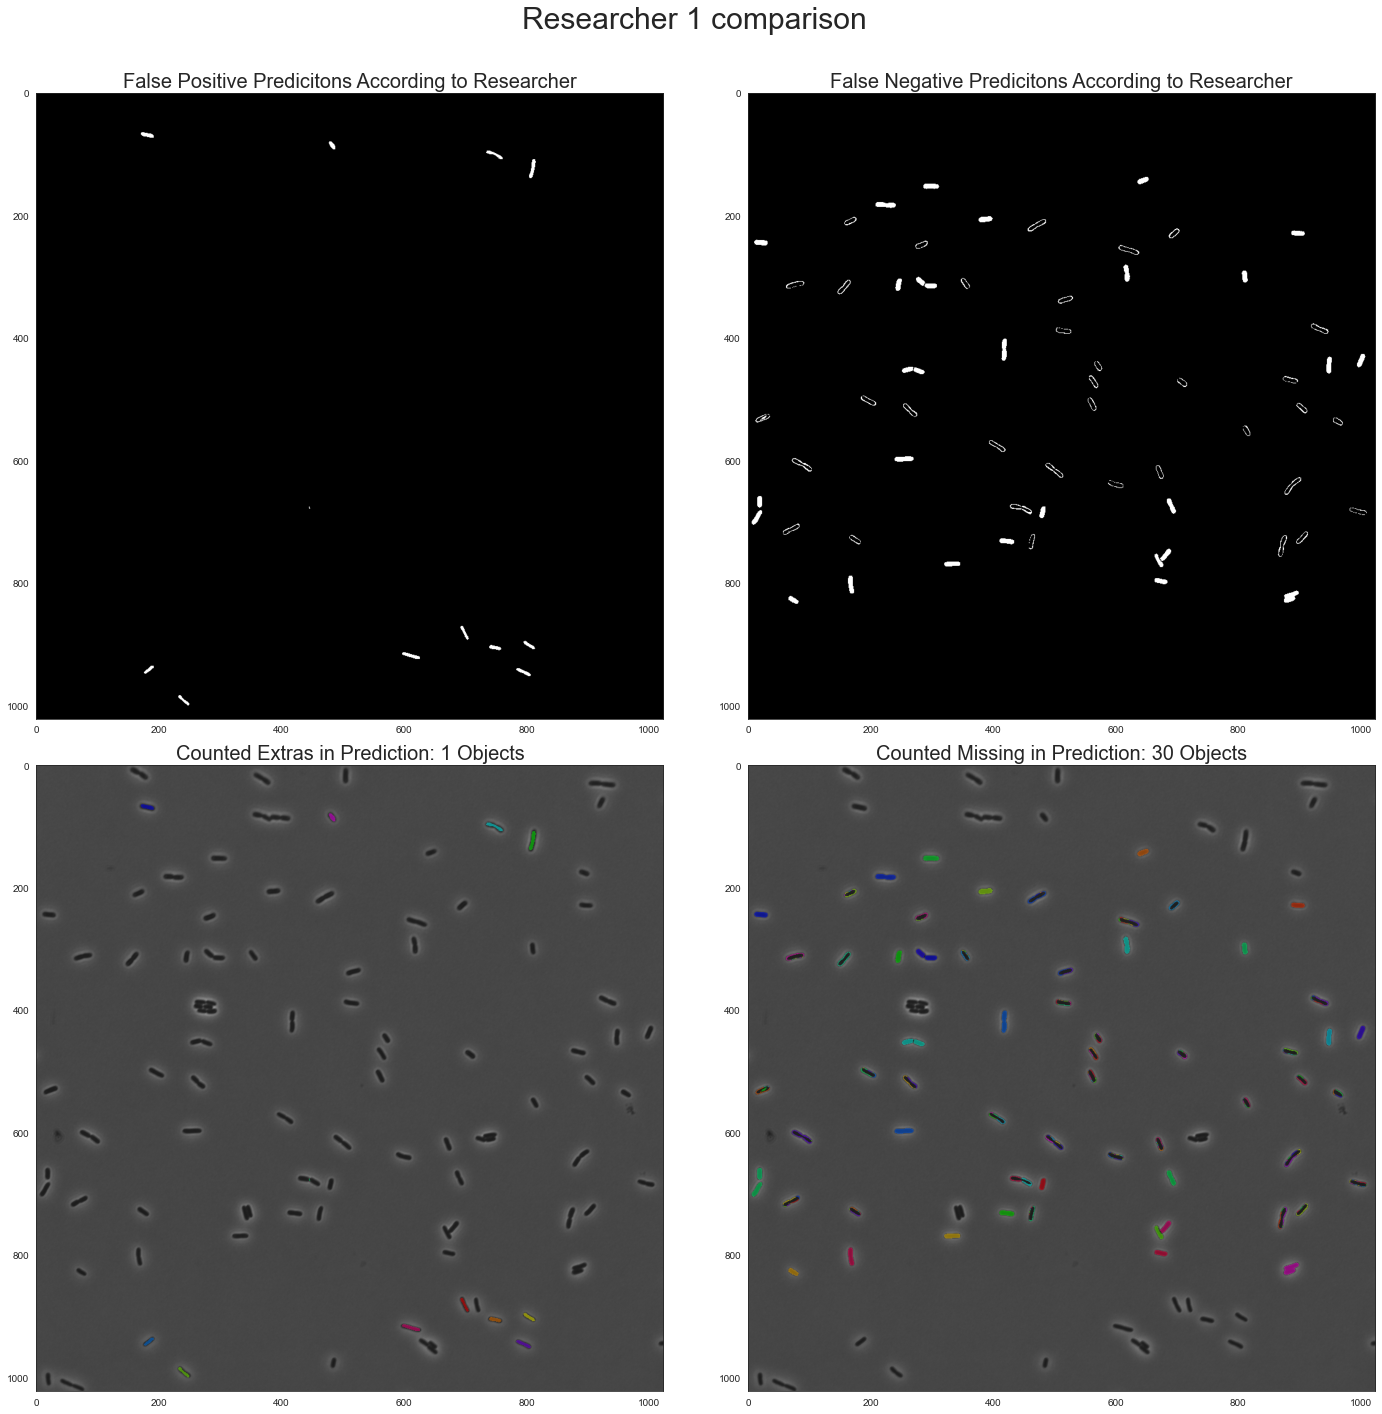

Experimental Loss: 9.700000000000001


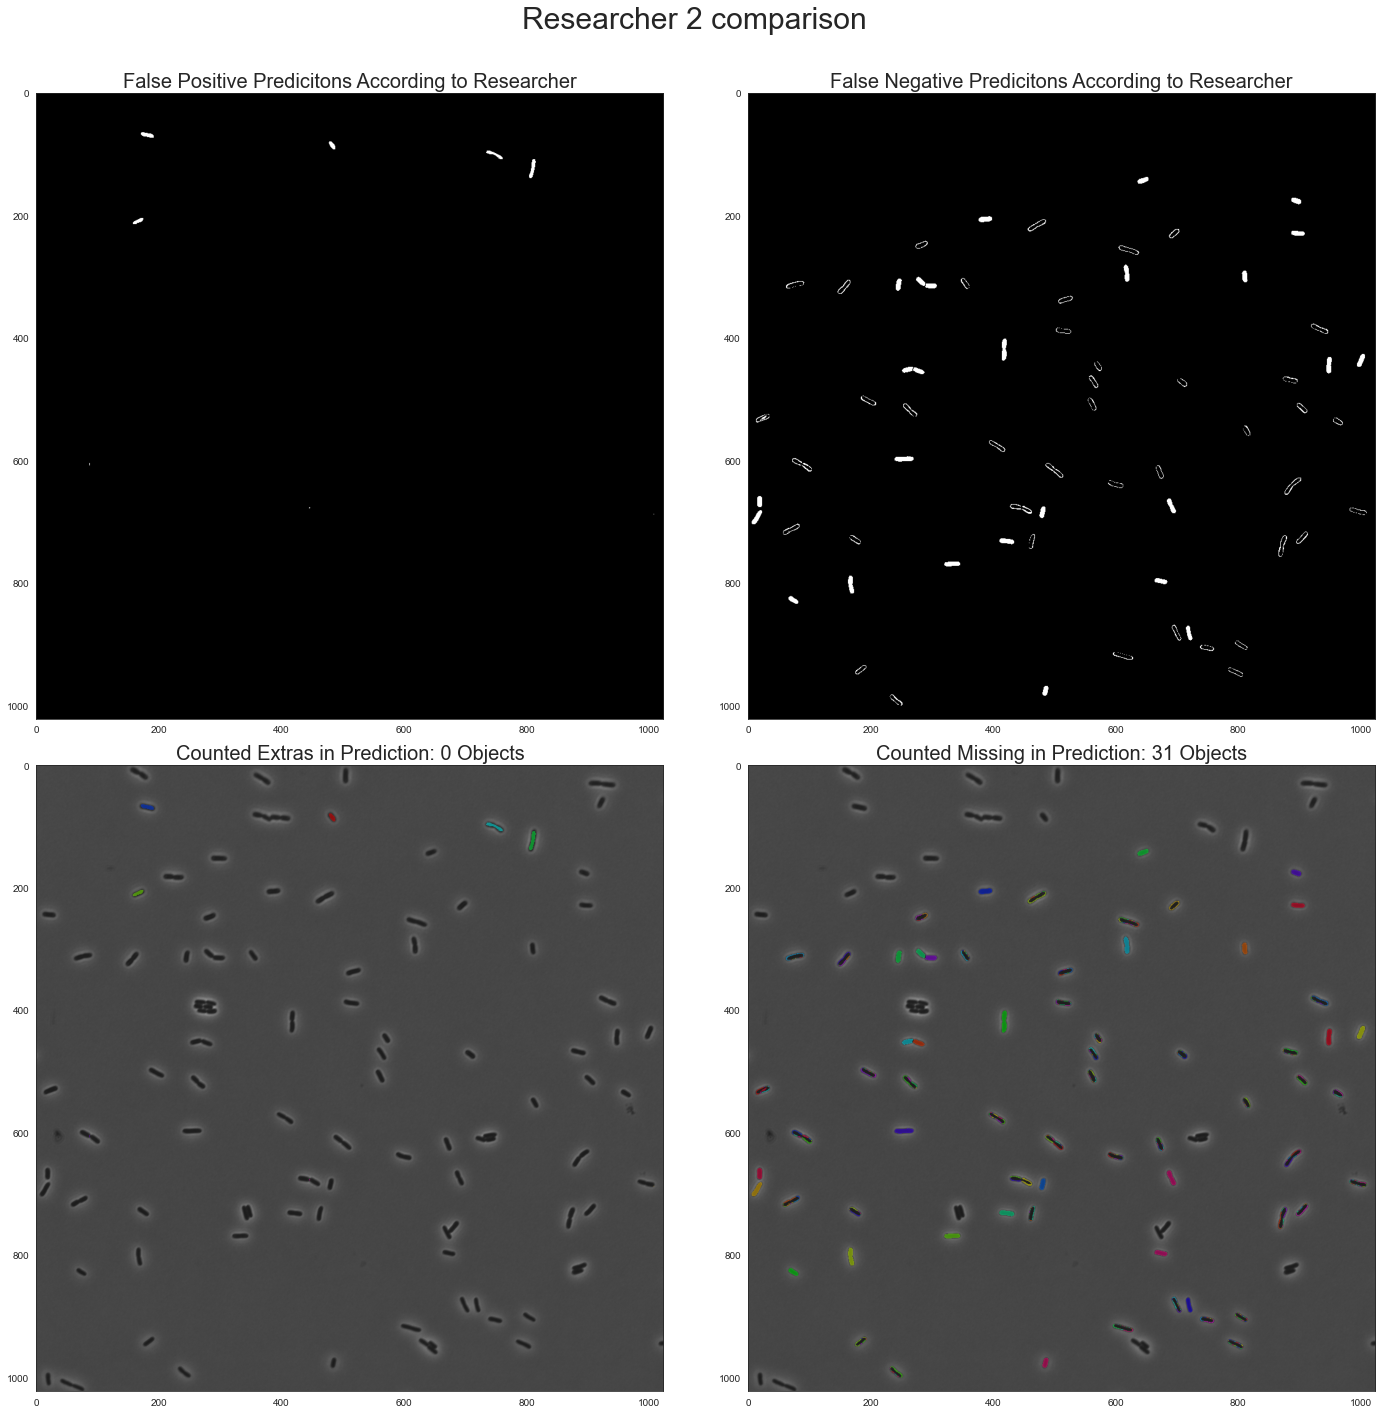

Experimental Loss: 9.3

Total Loss: 19.0
Valid Prediction: True


In [28]:
# visual count results for researcher 1
count_extras_res_1 = 1
count_missing_res_1 = 30

# visual count results for researcher 2
count_extras_res_2 = 0
count_missing_res_2 = 31

full_evaluation(ph3, cell_mask, ph3_thresh_res_1, count_extras_res_1, count_missing_res_1, ph3_thresh_res_2,
                count_extras_res_2, count_missing_res_2, counted_cell_disagreements, beta_cell, mask_evaluation_fig)

## Fluorescence Cluster Segmentation Models

In [29]:
beta_fluo = 0.15

In [30]:
fluo_cell_mixed_img = np.stack([ph3, fluo, fluo], axis=-1)

### U-Net

In [31]:
fluo_masks, fluo_boxes = keras_seg.full_segmentation(
    fluo_cell_mixed_img[None],
    'resources/models/config/fluo_unet.yaml',
    'resources/models/weights/fluo_unet_keras.hd5',
    preprocessor=MicroscopyPreprocessor,
    threshold=0.5,
)

fluo_mask = fluo_masks[0]

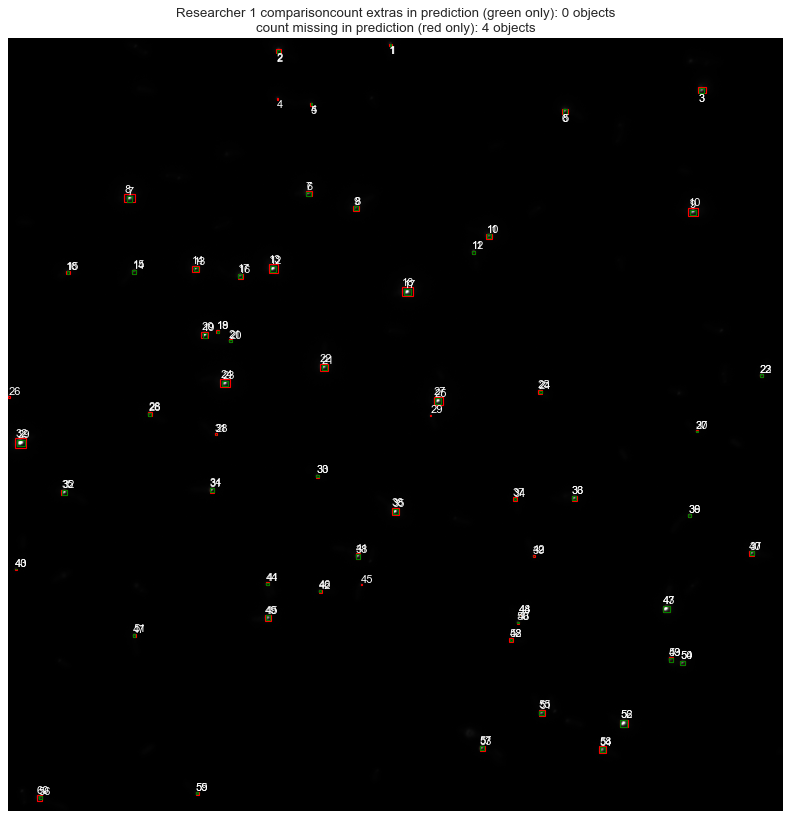

Experimental Loss: 3.4


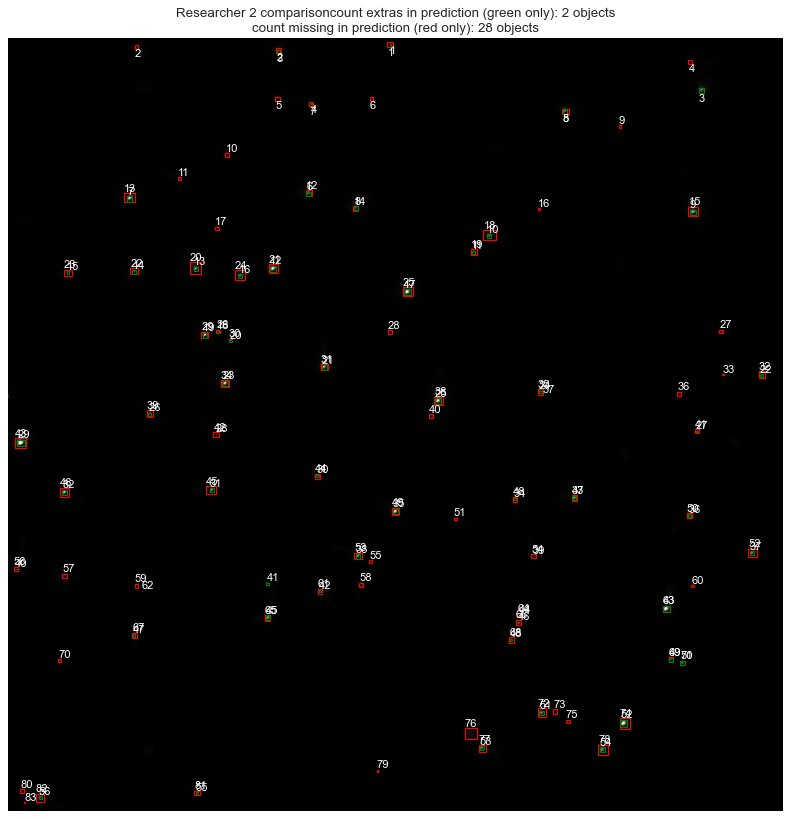

Experimental Loss: 24.1

Total Loss: 27.5
Valid Prediction: True


In [32]:
# visual count results for researcher 1
count_extras_res_1 = 0
count_missing_res_1 = 4

# visual count results for researcher 2
count_extras_res_2 = 2
count_missing_res_2 = 28

full_evaluation(fluo, fluo_mask, fluo_thresh_res_1, count_extras_res_1, count_missing_res_1, fluo_thresh_res_2,
                count_extras_res_2, count_missing_res_2, counted_fluo_disagreements, beta_fluo, box_evaluation_fig)

### FPN
Feature Pyramid Network segmentation model (https://arxiv.org/pdf/1612.03144.pdf).

In [33]:
fluo_masks, fluo_boxes = keras_seg.full_segmentation(
    fluo_cell_mixed_img[None],
    'resources/models/config/fluo_fpn.yaml',
    'resources/models/weights/fluo_fpn_keras.hd5',
    preprocessor=MicroscopyPreprocessor,
    threshold=0.5,
)

fluo_mask = fluo_masks[0]

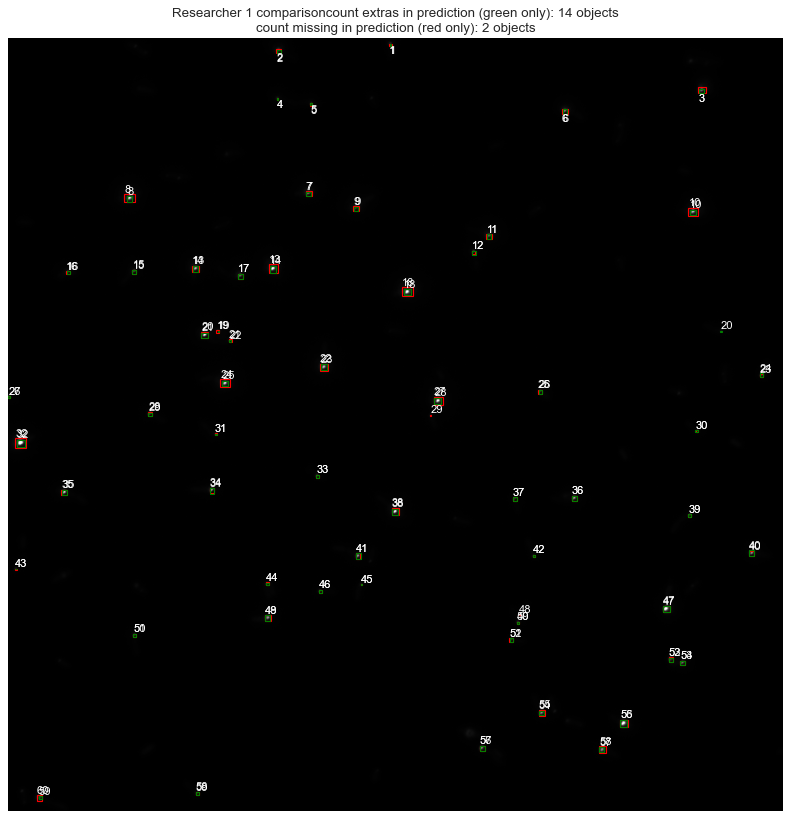

Experimental Loss: 3.8


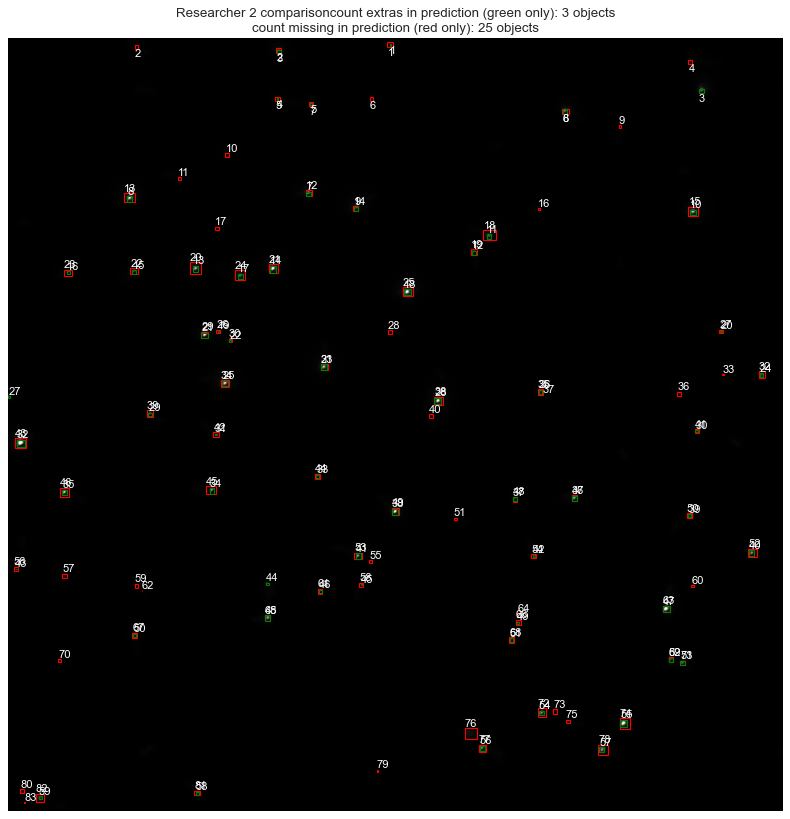

Experimental Loss: 21.7

Total Loss: 25.5
Valid Prediction: True


In [34]:
# visual count results for researcher 1
count_extras_res_1 = 14
count_missing_res_1 = 2

# visual count results for researcher 2
count_extras_res_2 = 3
count_missing_res_2 = 25

full_evaluation(fluo, fluo_mask, fluo_thresh_res_1, count_extras_res_1, count_missing_res_1, fluo_thresh_res_2,
                count_extras_res_2, count_missing_res_2, counted_fluo_disagreements, beta_fluo, box_evaluation_fig)